In [1]:
from pathlib import Path

import pandas as pd

from caveat.evaluate.describe import frequency, transitions

In [2]:
def latest(path: Path):
    versions = sorted(
        [
            d
            for d in path.iterdir()
            if d.is_dir() and d.name.startswith("version")
        ]
    )
    return path.name, versions[-1]


def iter_models(path: Path):
    for dir in path.iterdir():

        if dir.is_dir():

            yield latest(dir)


def find_best(path: Path):

    ranks = (
        pd.read_csv(path / "domain_distances.csv")
        .drop(columns=["domain", "observed", "mean", "std"], errors="ignore")
        .rank(axis=1, method="min")
        .sum(axis=0)
    )
    ranked = [i for _, i in sorted(zip(ranks, ranks.index))]
    top = ranked[0]
    dir = path / top
    yield latest(dir)


next(find_best(Path("../logs/paper_d_rnn")))

('DiscLSTM2', PosixPath('../logs/paper_d_rnn/DiscLSTM2/version_0'))

In [3]:
# find data
target_schedules = pd.read_csv("../tmp/nts_home_schedules.csv")
acts = list(target_schedules.act.value_counts(ascending=False).index)
class_map = {n: i for i, n in enumerate(acts)}

In [ ]:
from datetime import datetime, timedelta
from typing import Optional

from matplotlib import pyplot as plt
from pandas import DataFrame

from caveat.evaluate.features.frequency import binned_activity_density


def plot_agg_acts(
    name: str,
    population: DataFrame,
    class_map: dict,
    duration: int = 1440,
    step: int = 10,
    ax=None,
    legend=True,
    **kwargs,
):
    bins = binned_activity_density(
        population, duration=duration, step=step, class_map=class_map
    )
    columns = list(class_map.keys())
    totals = bins.sum(0)
    sorted_cols = [x for _, x in sorted(zip(totals, columns))]
    df = DataFrame(bins, columns=columns)[sorted_cols]
    df.index = [
        datetime(2021, 11, 1, 0) + timedelta(minutes=i * step)
        for i in range(len(df.index))
    ]
    fig = df.plot(kind="bar", stacked=True, width=1, ax=ax, **kwargs)
    if legend:
        ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), frameon=False)
    ax = fig.axes
    labels = [" " for _ in range(len(df.index))]
    labels[:: int(120 / step)] = [x.strftime("%H:%M") for x in df.index][
        :: int(120 / step)
    ]
    ax.set_xticklabels(labels)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    ax.set_xlabel("Time of day")
    ax.set_ylabel("Activity Density")
    ax.set_title(name)
    return ax


def frequency_plots(
    observed: DataFrame, ys: Optional[dict[DataFrame]], **kwargs
):
    if ys is None:
        ys = dict()
    acts = list(observed.act.value_counts(ascending=False).index)

    class_map = {n: i for i, n in enumerate(acts)}

    fig, axs = plt.subplots(
        sharex=True,
        sharey=True,
        ncols=1,
        nrows=len(ys) + 1,
        figsize=kwargs.pop("figsize", (6, 12)),
    )

    if not ys:
        ax = axs
    else:
        ax = axs[0]

    plot_agg_acts("Observed", observed, class_map, ax=ax, legend=True, **kwargs)

    # now deal with ys
    for i, (name, y) in enumerate(ys.items()):
        ax = axs[i + 1]
        frequency.plot_agg_acts(
            name, y, class_map, ax=ax, legend=False, **kwargs
        )

    fig.tight_layout()
    fig.subplots_adjust(right=0.75)

    return fig

                     medical    escort      shop  visit  education  other  \
2021-11-01 00:00:00      0.0  0.000000  0.000000    0.0        0.0    0.0   
2021-11-01 00:10:00      0.0  0.000054  0.000027    0.0        0.0    0.0   
2021-11-01 00:20:00      0.0  0.000054  0.000027    0.0        0.0    0.0   
2021-11-01 00:30:00      0.0  0.000054  0.000027    0.0        0.0    0.0   
2021-11-01 00:40:00      0.0  0.000080  0.000027    0.0        0.0    0.0   

                     work      home  
2021-11-01 00:00:00   0.0  1.000000  
2021-11-01 00:10:00   0.0  0.999920  
2021-11-01 00:20:00   0.0  0.999920  
2021-11-01 00:30:00   0.0  0.999920  
2021-11-01 00:40:00   0.0  0.999893  


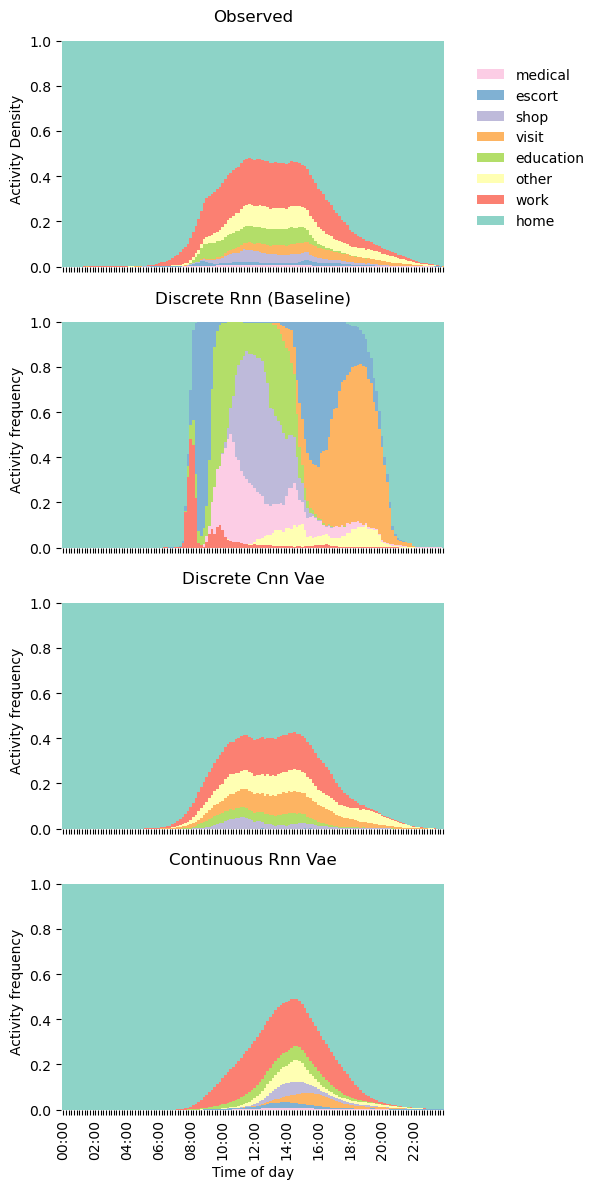

In [29]:
cmap = {
    "home": (0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    "other": (1.0, 1.0, 0.7019607843137254),
    "shop": (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
    "work": (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
    "escort": (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
    "visit": (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
    "education": (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
    "medical": (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
    "travel": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
}


batch_paths = {
    "Discrete RNN (Baseline)": Path("../logs/paper_d_rnn"),
    "Discrete CNN VAE": Path("../logs/paper_d_cnn_vae_3"),
    "Continuous RNN VAE": Path("../logs/paper_c_rnn_vae"),
    # "Continuous RNN JVAE": Path("../logs/paper_c_rnn_Jvae"),
}


schedules = {
    n: pd.read_csv(next(find_best(p))[1] / "synthetic_schedules.csv")
    for n, p in batch_paths.items()
}
fig = frequency_plots(target_schedules, schedules, color=cmap)
# fig = sequence_prob_plot(target_schedules, schedules, cmap=cmap)

In [30]:
from typing import Optional, Tuple

from matplotlib.axes import Axes
from matplotlib.colors import ListedColormap as CMap
from matplotlib.figure import Figure
from matplotlib.patches import Patch
from pandas import DataFrame

from caveat.evaluate.features.transitions import sequence_probs


def _probs_plot(
    population: DataFrame, acts: list[str], cmap: Optional[CMap], ax=Axes
) -> Tuple[Figure, Axes]:
    probs = sequence_probs(population)
    accumulated = probs[::-1].cumsum()[::-1]

    ys = []
    widths = []
    heights = []
    lefts = []
    cols = []
    for idx, p, ap in zip(probs.index, probs, accumulated):
        seq = idx[1].split(">")
        width = 1 / len(seq)
        for i, act in enumerate(seq):
            ys.append(ap - p)
            widths.append(width)
            heights.append(p)
            lefts.append(i * width)
            cols.append(cmap[act])

    ax.barh(
        y=ys, width=widths, height=heights, left=lefts, color=cols, align="edge"
    )
    ax.hlines(ys, xmin=0, xmax=1, color="white", linewidth=0.1)
    ax.axis("off")


def sequence_prob_plot(
    observed: DataFrame, ys: Optional[dict[DataFrame]], **kwargs
) -> Figure:
    acts = list(observed.act.value_counts(ascending=False).index)
    cmap = kwargs.pop("cmap", None)
    if cmap is None:
        cmap = plt.cm.Set1_r
        colors = cmap.colors
        factor = (len(acts) // len(colors)) + 1
        cmap = dict(zip(acts, colors * factor))

    fig, axs = plt.subplots(
        len(ys) + 1,
        1,
        figsize=kwargs.pop("figsize", (5, 18)),
        sharex=True,
        sharey=True,
        tight_layout=True,
    )
    acts = list(observed.act.value_counts(ascending=False).index)
    _probs_plot(observed, acts, ax=axs[0], cmap=cmap)
    observed_title = kwargs.pop("observed_title", "Observed")
    axs[0].set_title(observed_title)
    if ys is None:
        return fig
    for i, (name, y) in enumerate(ys.items()):
        _probs_plot(y, acts, ax=axs[i + 1], cmap=cmap)
        axs[i + 1].set_title(name)

    elements = [Patch(facecolor=cmap[act], label=act.title()) for act in acts]
    axs[0].legend(
        handles=elements,
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
    )

    return fig

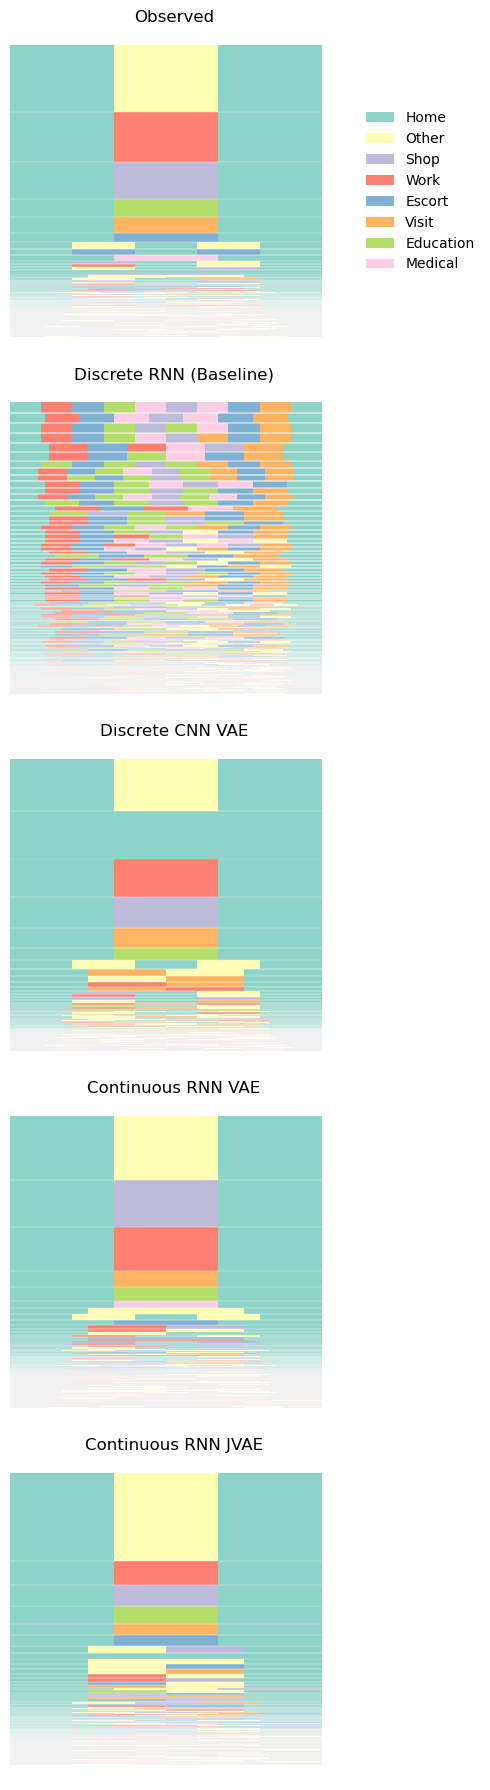

In [31]:
cmap = {
    "home": (0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    "other": (1.0, 1.0, 0.7019607843137254),
    "shop": (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
    "work": (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
    "escort": (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
    "visit": (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
    "education": (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
    "medical": (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
}


batch_paths = {
    "Discrete RNN (Baseline)": Path("../logs/paper_d_rnn"),
    "Discrete CNN VAE": Path("../logs/paper_d_cnn_vae_3"),
    "Continuous RNN VAE": Path("../logs/paper_c_rnn_vae"),
    "Continuous RNN JVAE": Path("../logs/paper_c_rnn_Jvae"),
}


schedules = {
    n: pd.read_csv(next(find_best(p))[1] / "synthetic_schedules.csv")
    for n, p in batch_paths.items()
}
# fig = frequency_plots(target_schedules, schedules)
fig = sequence_prob_plot(target_schedules, schedules, cmap=cmap)


# next(iter_models(batch_paths[0]))

/tmp/ipykernel_1714639/2990192449.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
/tmp/ipykernel_1714639/2990192449.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return schedules.groupby(schedules.pid).apply(stretcher)
/tmp/ipykernel_1714639/2990192449.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the groupi

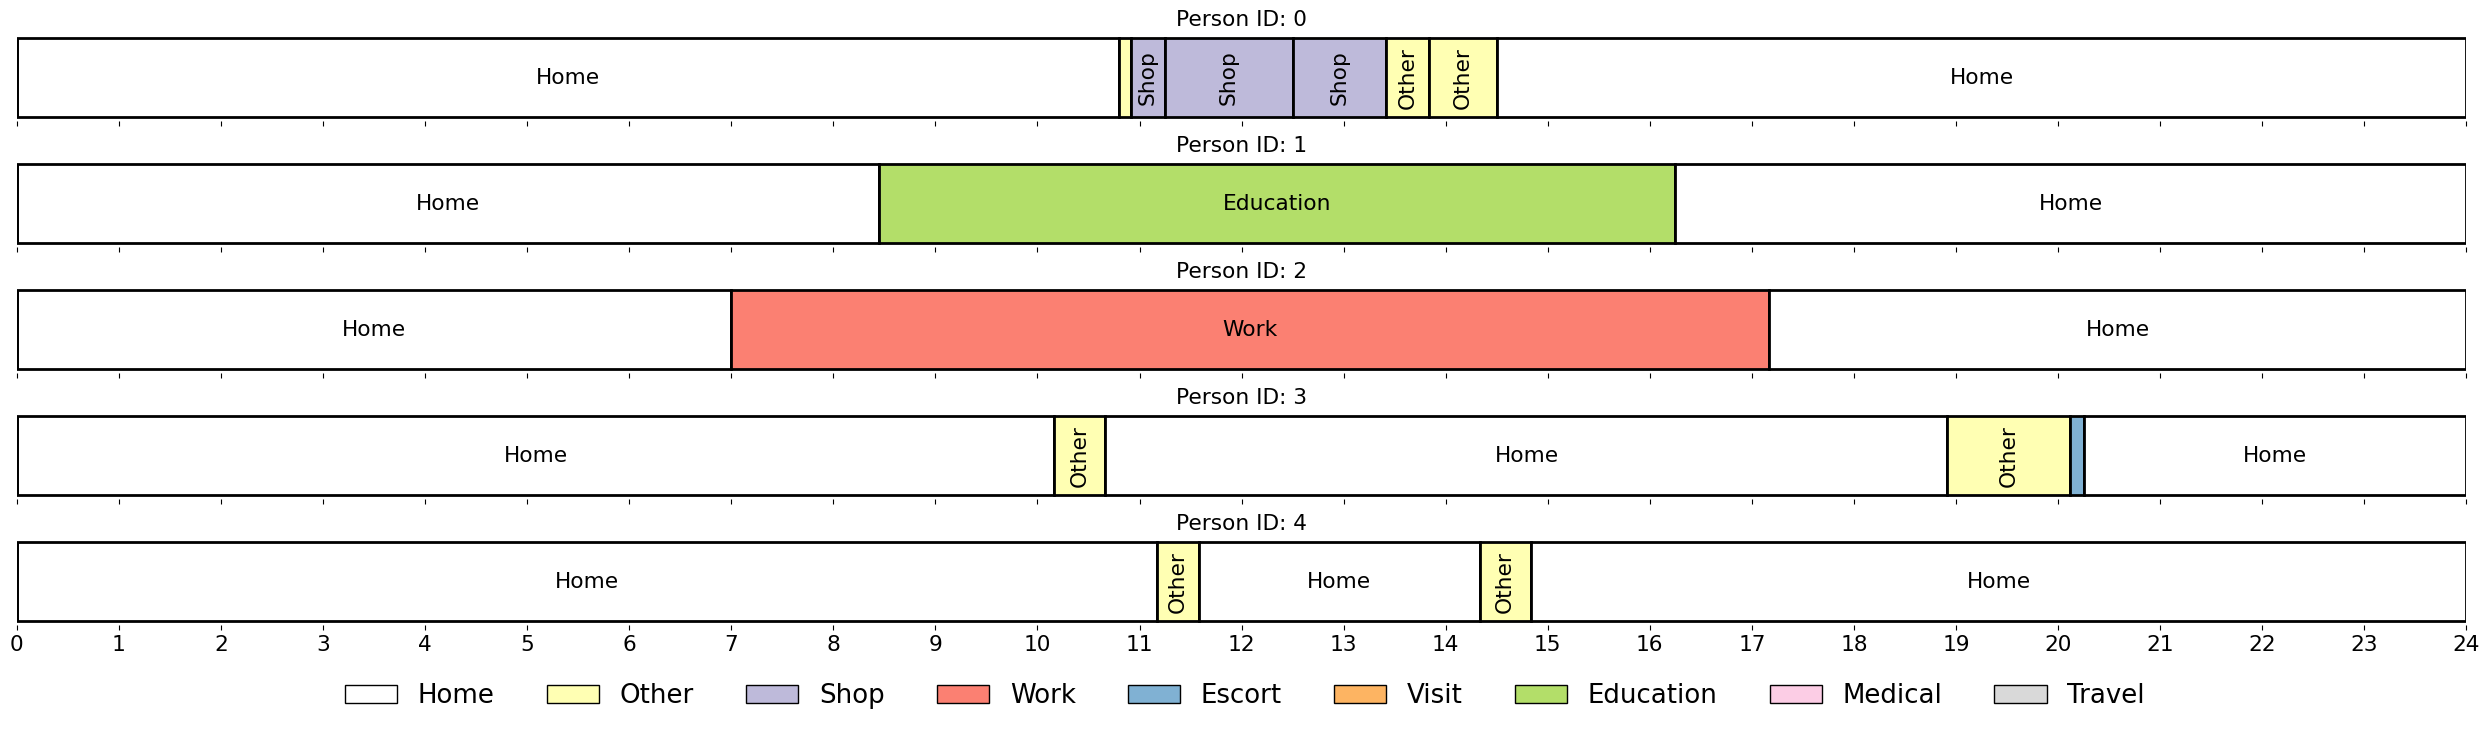

In [ ]:
import random

from pam.core import Household, Person
from pam.plot.plans import plot_household

from caveat.data.utils import trace_to_pam


def stretch(schedules):
    return schedules.groupby(schedules.pid).apply(stretcher)


def stretcher(schedule):
    duration = schedule.duration.sum()
    if duration != 1440:
        a = 1440 / duration
        schedule.duration = (schedule.duration * a).astype(int)
        accumulated = list(schedule.duration.cumsum())
        schedule.start = [0] + accumulated[:-1]
        schedule.end = accumulated
    return schedule


def trim(schedules):
    schedules[schedules.end > 1440] = 1440
    schedules[schedules.start > 1440] = 1440
    schedules.duration = schedules.end - schedules.start
    schedules = schedules[schedules.duration > 0]
    return schedules


def pad(schedules):
    return (
        schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
    )


def padder(schedule):
    if schedule.end.iloc[-1] < 1440 and schedule.act.iloc[-1] != "home":
        pid = schedule.pid.iloc[0]
        schedule = pd.concat(
            [
                schedule,
                DataFrame(
                    {
                        "pid": pid,
                        "start": schedule.end.iloc[-1],
                        "end": 1440,
                        "duration": 1440 - schedule.end.iloc[-1],
                        "act": "home",
                    },
                    index=[0],
                ),
            ]
        )
    elif schedule.end.iloc[-1] < 1440:
        schedule.end.iloc[-1] = 1440
        schedule.duration.iloc[-1] = 1440 - schedule.start.iloc[-1]
    return schedule


def plot_schedules(schedules, **kwargs):

    cmap = {
        "home": (0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
        "other": (1.0, 1.0, 0.7019607843137254),
        "shop": (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
        "work": (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
        "escort": (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
        "visit": (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
        "education": (
            0.7019607843137254,
            0.8705882352941177,
            0.4117647058823529,
        ),
        "medical": (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
        "travel": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
    }
    cmap = {n.title(): c for n, c in cmap.items()}

    hh = Household("")

    pids = schedules.pid
    selected = random.sample(list(pids), 5)
    for i, pid in enumerate(selected):
        person = Person(pid)
        plan = schedules[schedules.pid == pid]
        plan = trim(stretch(pad(plan)))[["act", "start", "end", "duration"]]
        mapping = {a: a for a in plan.act}

        trace = [
            (row.act, row.start, row.end, row.duration)
            for i, row in plan.iterrows()
        ]
        plan = trace_to_pam(trace, mapping)

        person = Person(i)
        person.plan = plan
        hh.add(person)

    plot_household(hh, cmap=cmap, width=25)


plot_schedules(target_schedules)

/tmp/ipykernel_6468/21139031.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
/tmp/ipykernel_6468/21139031.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return schedules.groupby(schedules.pid).apply(stretcher)
/tmp/ipykernel_6468/21139031.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. Thi

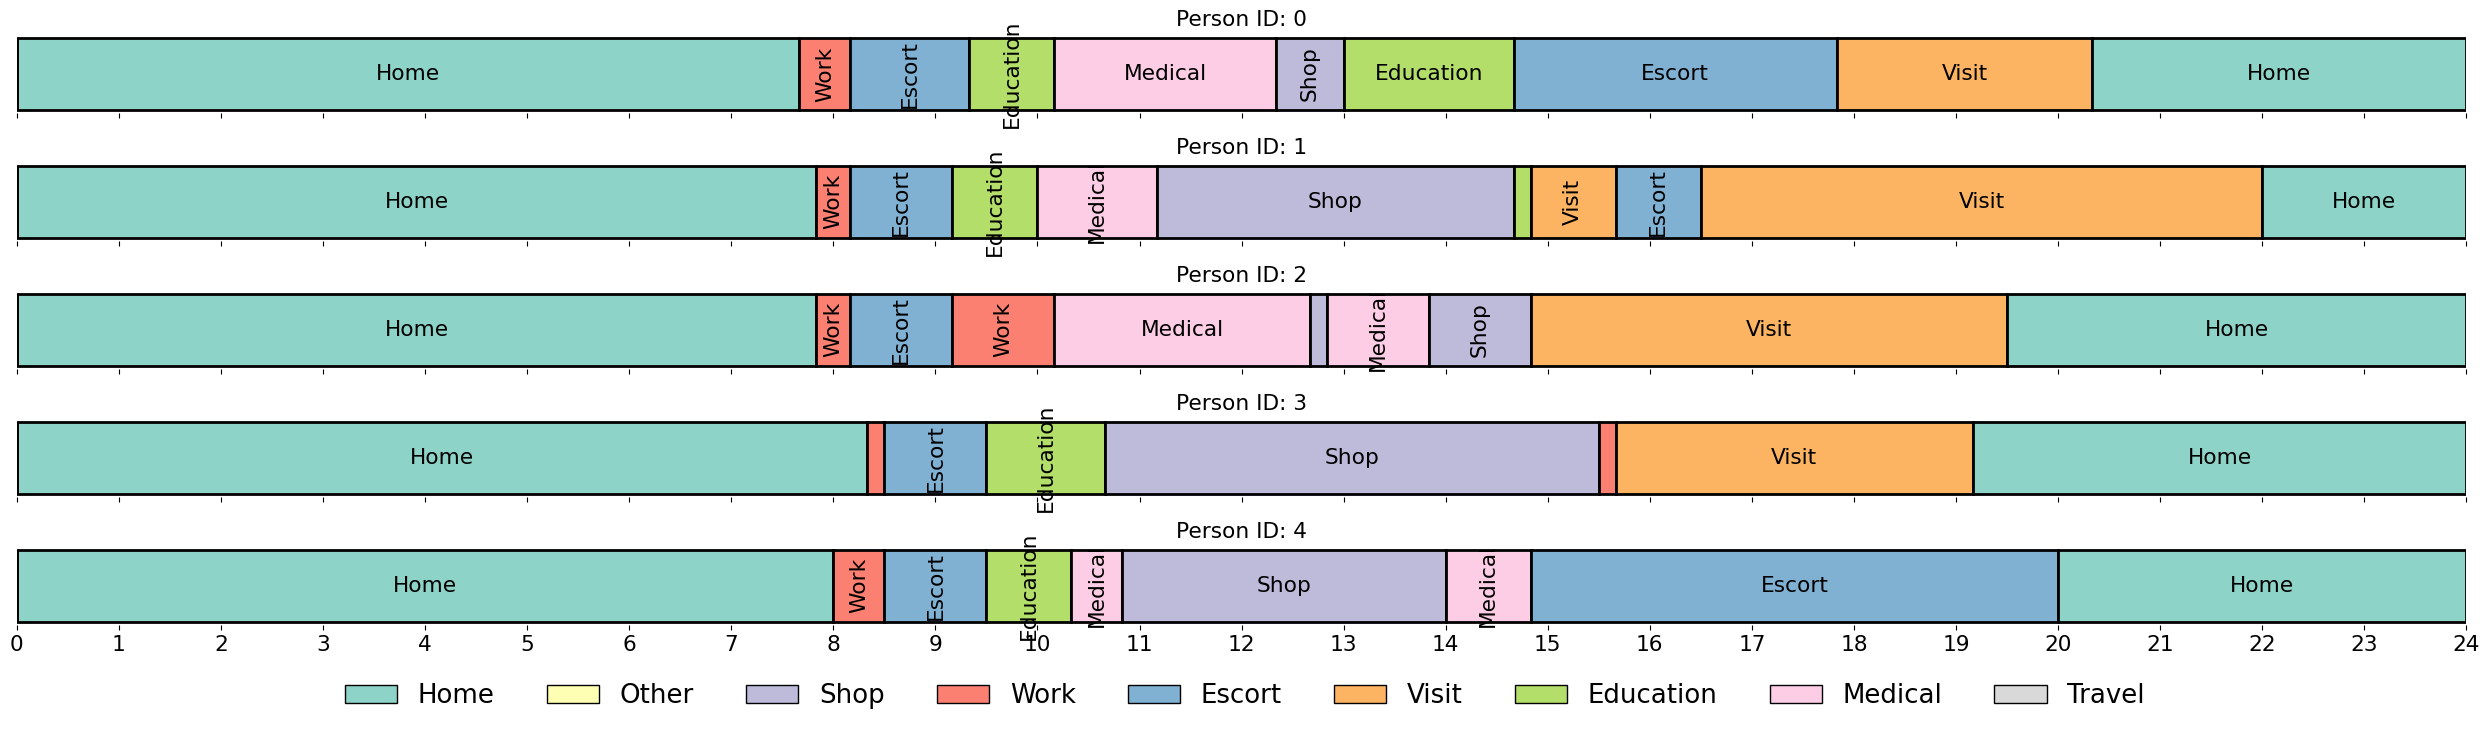

In [90]:
p = batch_paths["Discrete RNN (Baseline)"]
schedules = pd.read_csv(next(find_best(p))[1] / "synthetic_schedules.csv")

plot_schedules(schedules)

/tmp/ipykernel_6468/21139031.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
/tmp/ipykernel_6468/21139031.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return schedules.groupby(schedules.pid).apply(stretcher)
/tmp/ipykernel_6468/21139031.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. Thi

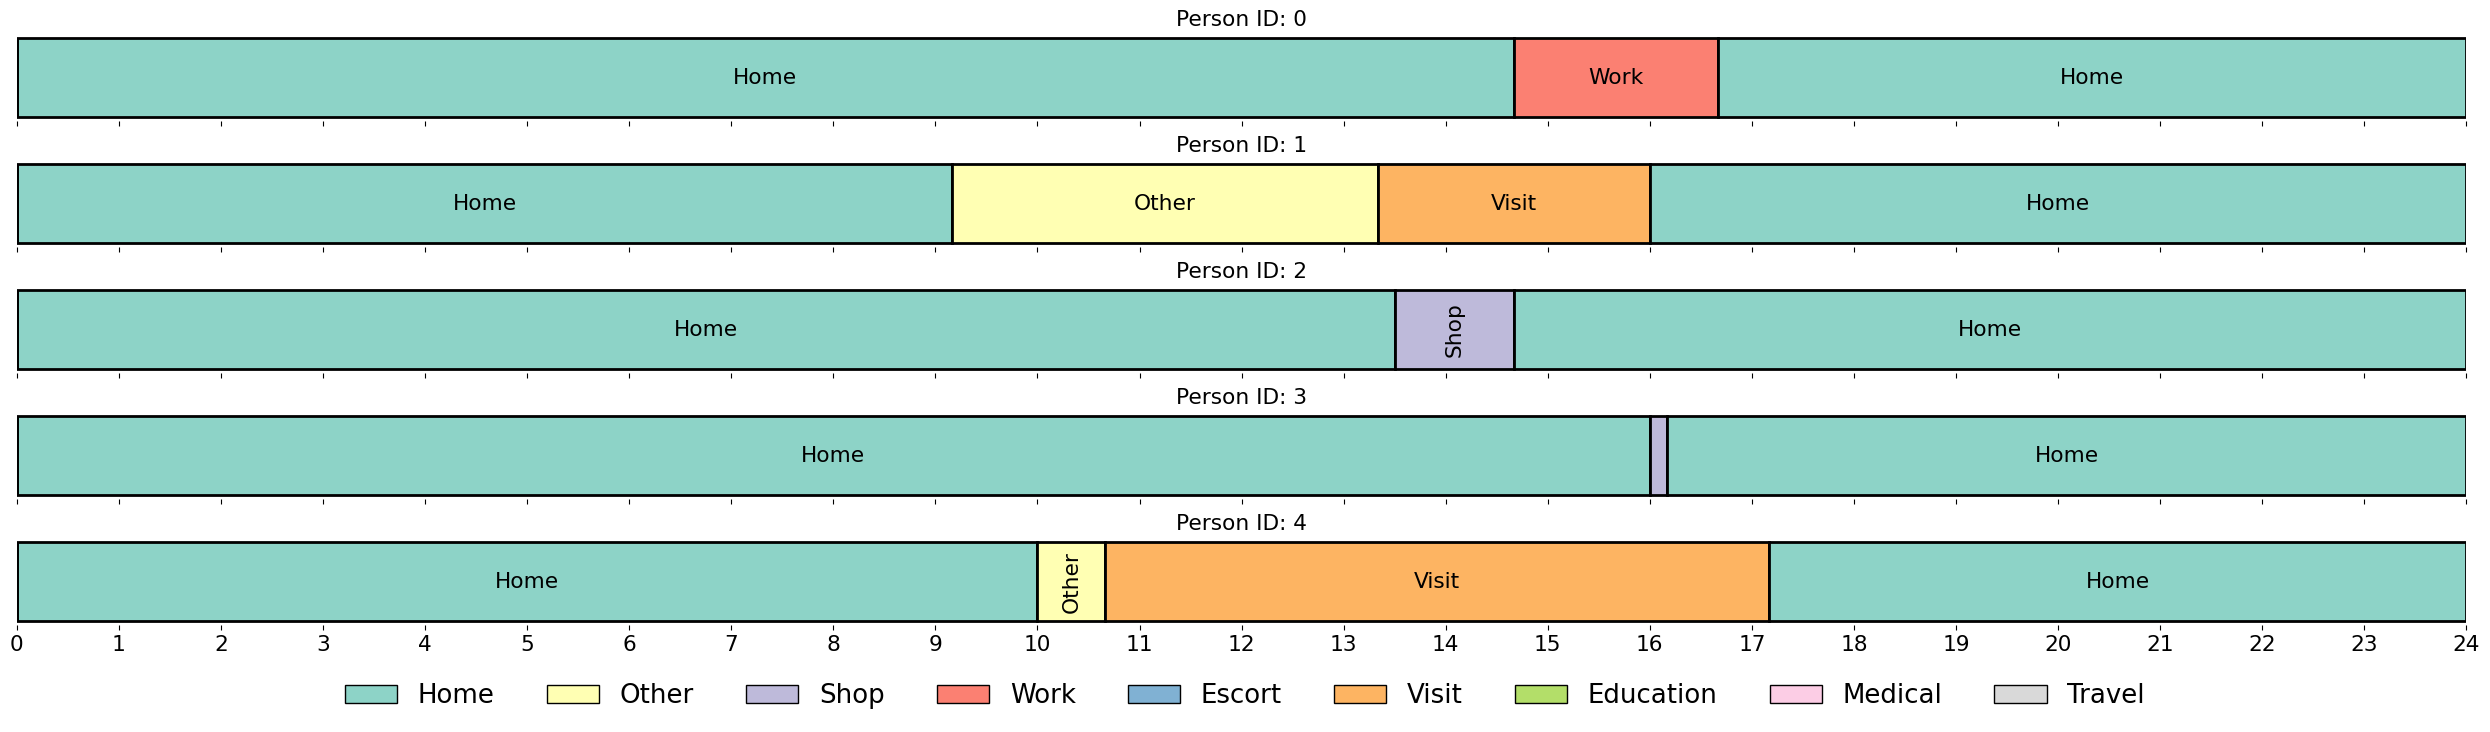

In [93]:
p = batch_paths["Discrete CNN VAE"]
schedules = pd.read_csv(next(find_best(p))[1] / "synthetic_schedules.csv")

plot_schedules(schedules)

/tmp/ipykernel_1872654/1104284722.py:55: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  schedule.end.iloc[-1] = 1440
/tmp/ipykernel_1872654/1104284722.py:56: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are 

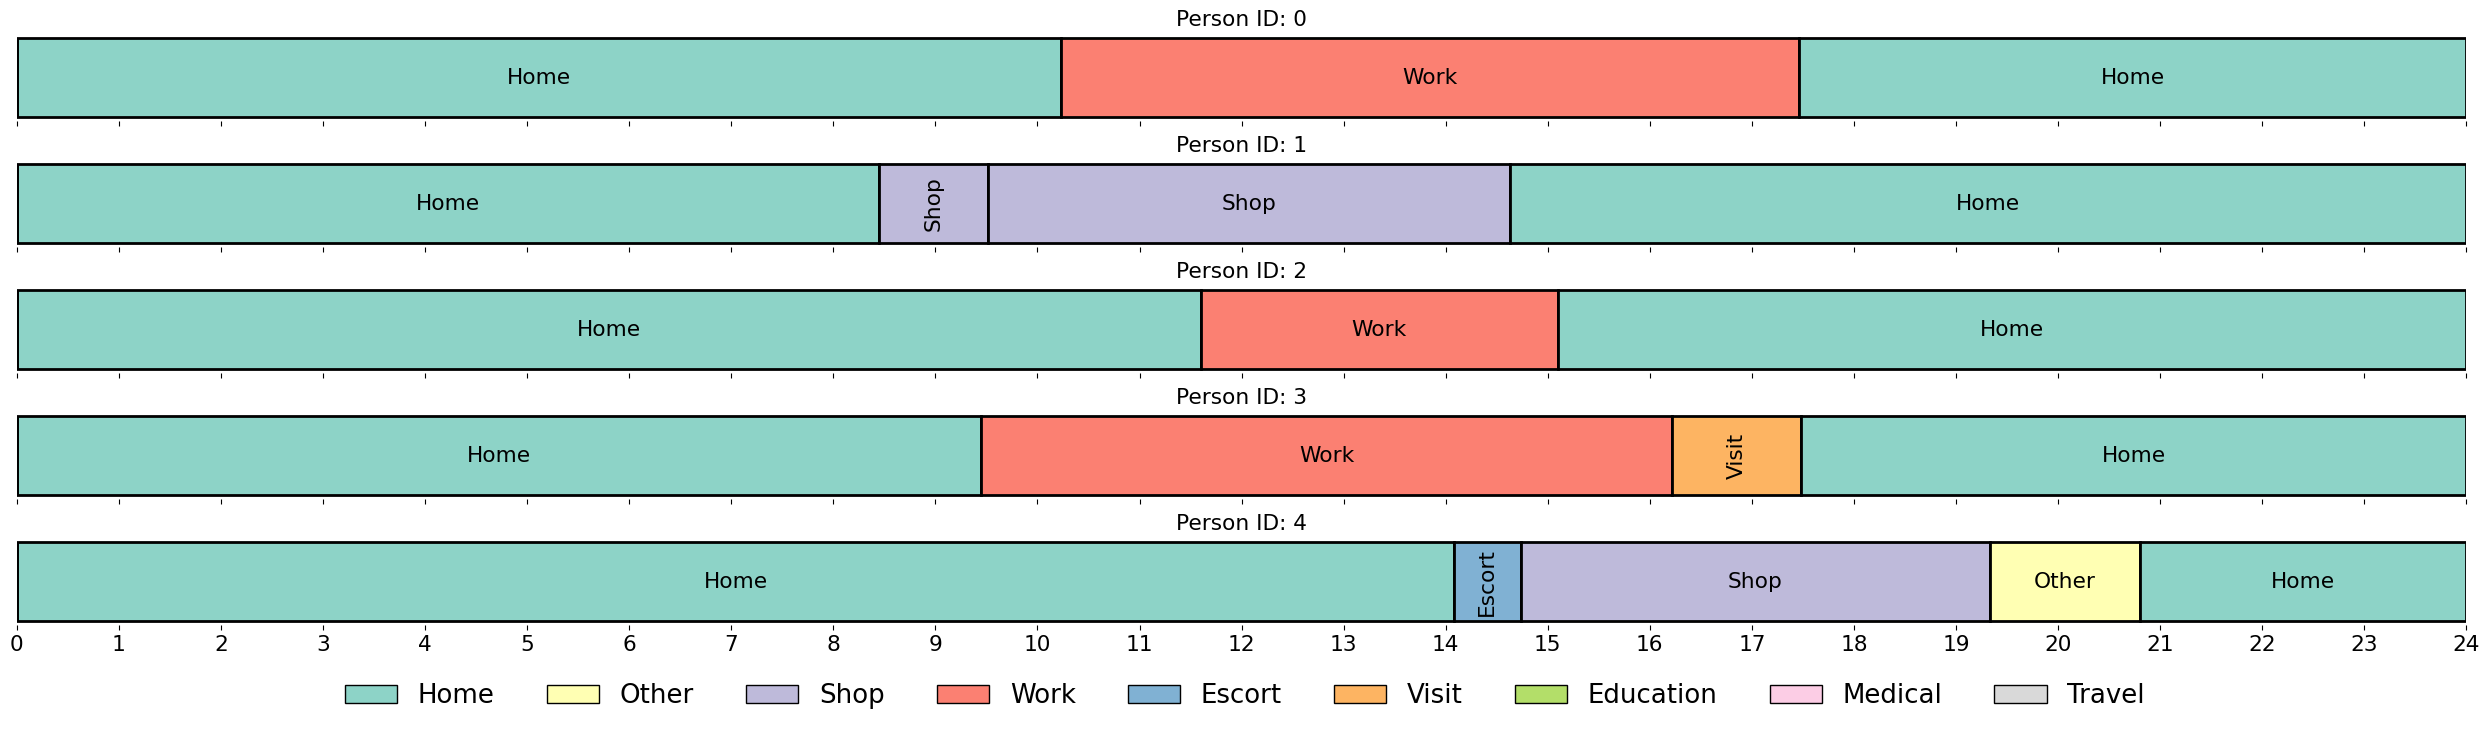

In [324]:
p = batch_paths["Continuous RNN VAE"]
schedules = pd.read_csv(next(find_best(p))[1] / "synthetic_schedules.csv")

plot_schedules(schedules)

/tmp/ipykernel_1872654/1104284722.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
/tmp/ipykernel_1872654/1104284722.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return schedules.groupby(schedules.pid).apply(stretcher)
/tmp/ipykernel_1872654/1104284722.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the groupin

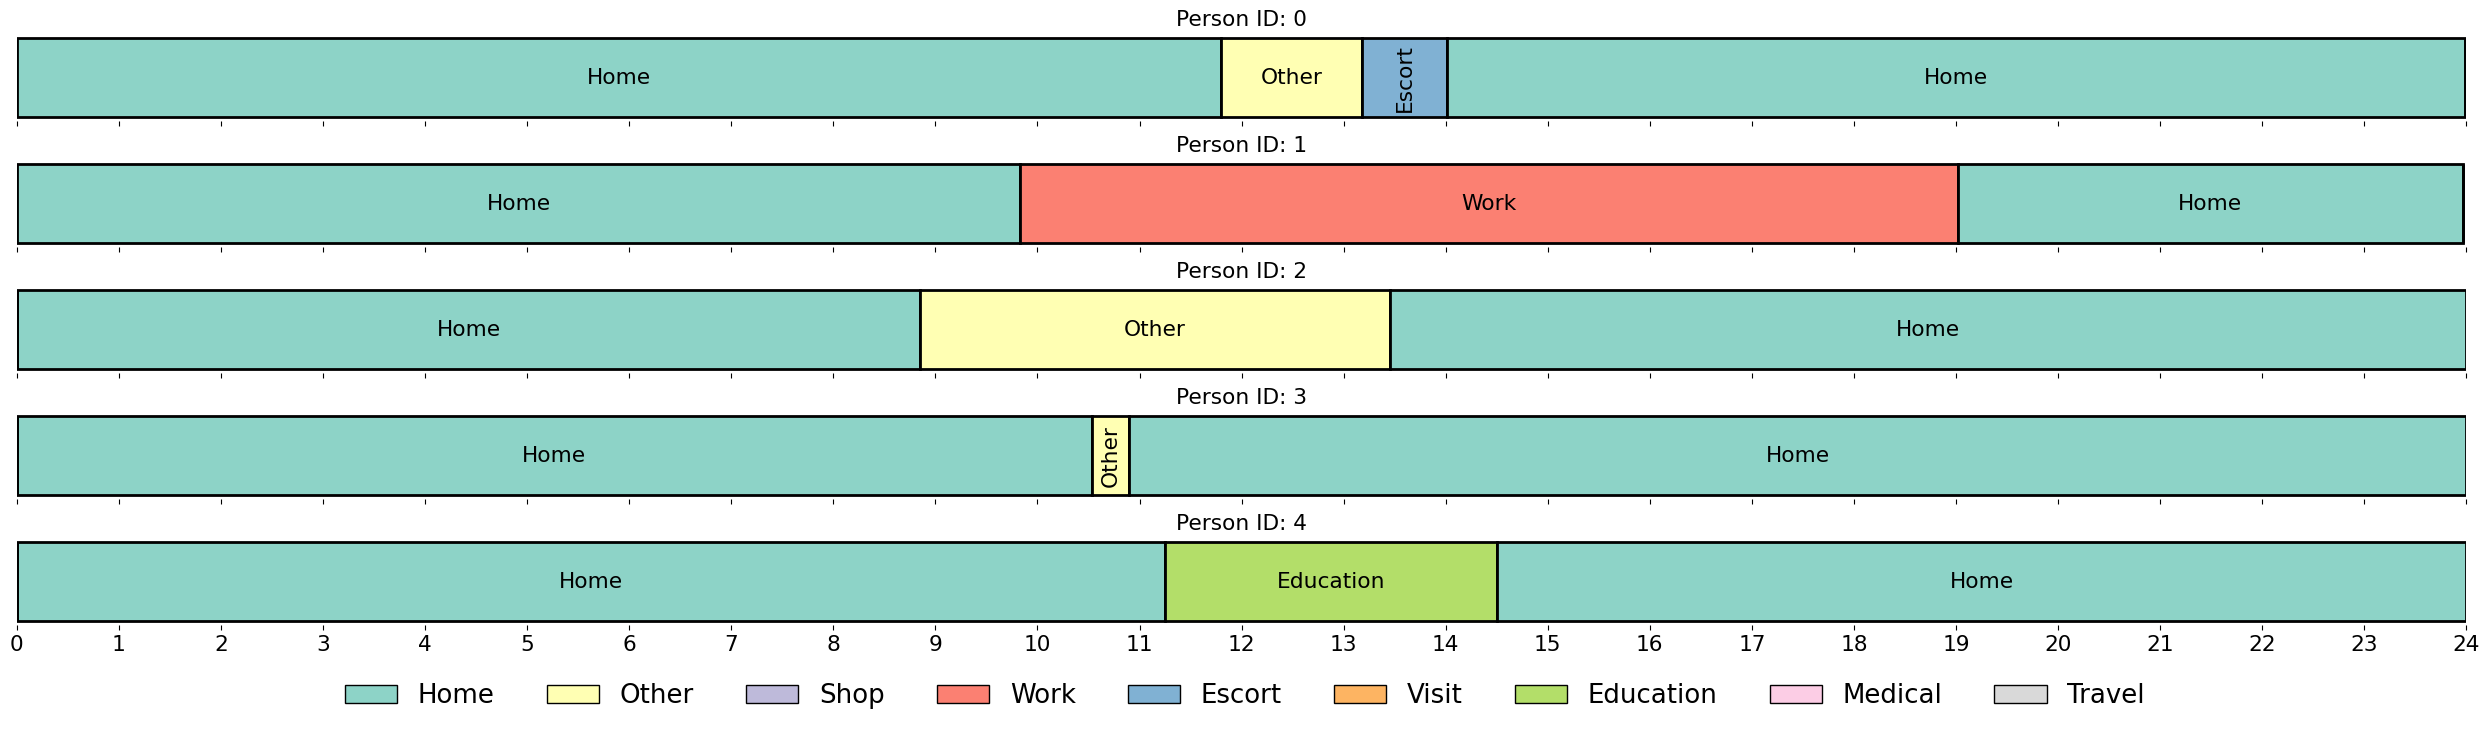

In [319]:
p = batch_paths["Continuous RNN JVAE"]
schedules = pd.read_csv(next(find_best(p))[1] / "synthetic_schedules.csv")

plot_schedules(schedules)

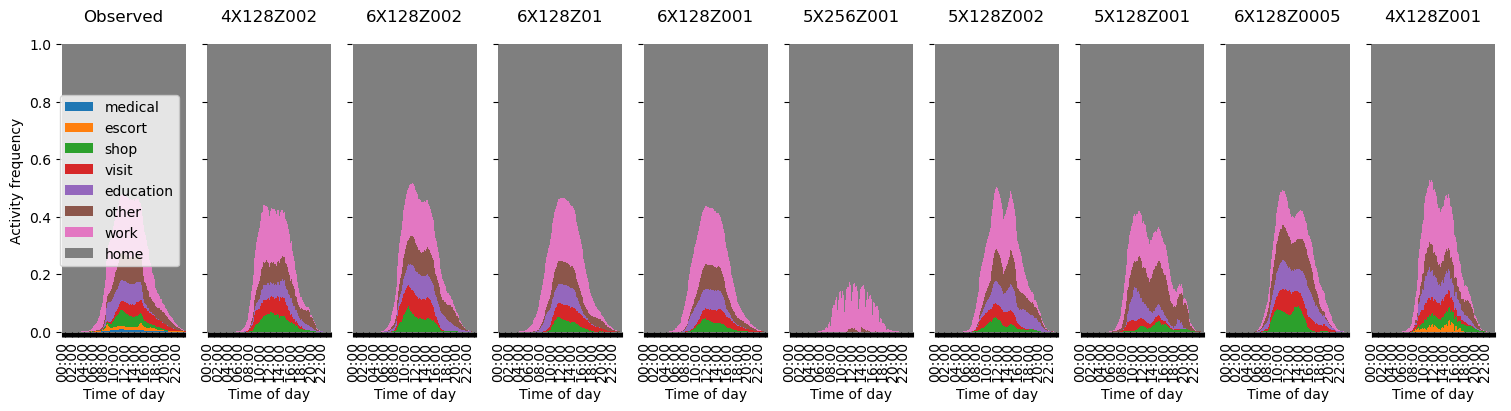

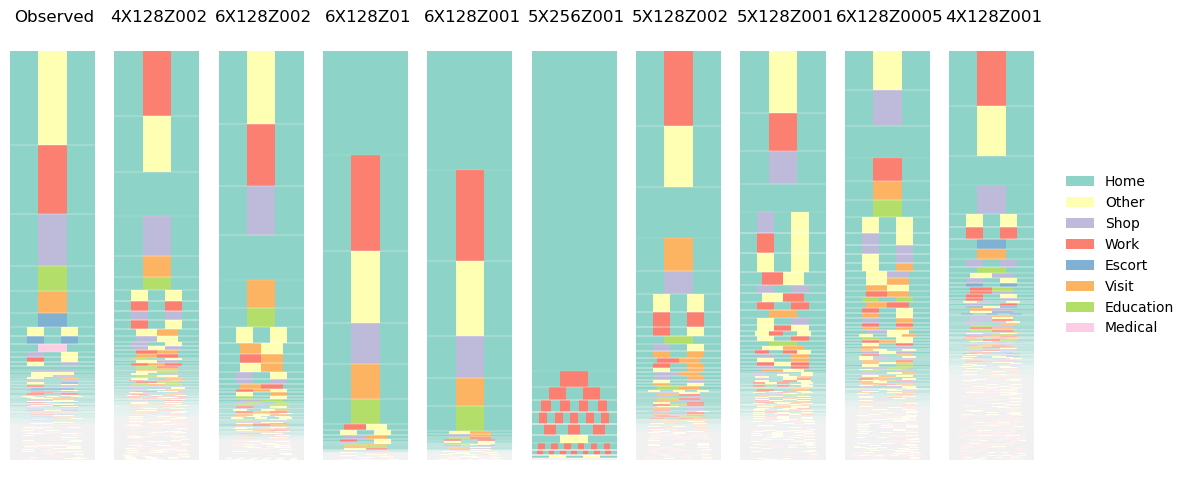

In [34]:
batch_path = Path("../logs/search_d_cnn_vae")
schedules = {
    n: pd.read_csv(p / "synthetic_schedules.csv")
    for n, p in iter_models(batch_path)
}
fig = frequency.frequency_plots(target_schedules, schedules)
fig = transitions.sequence_prob_plot(target_schedules, schedules)

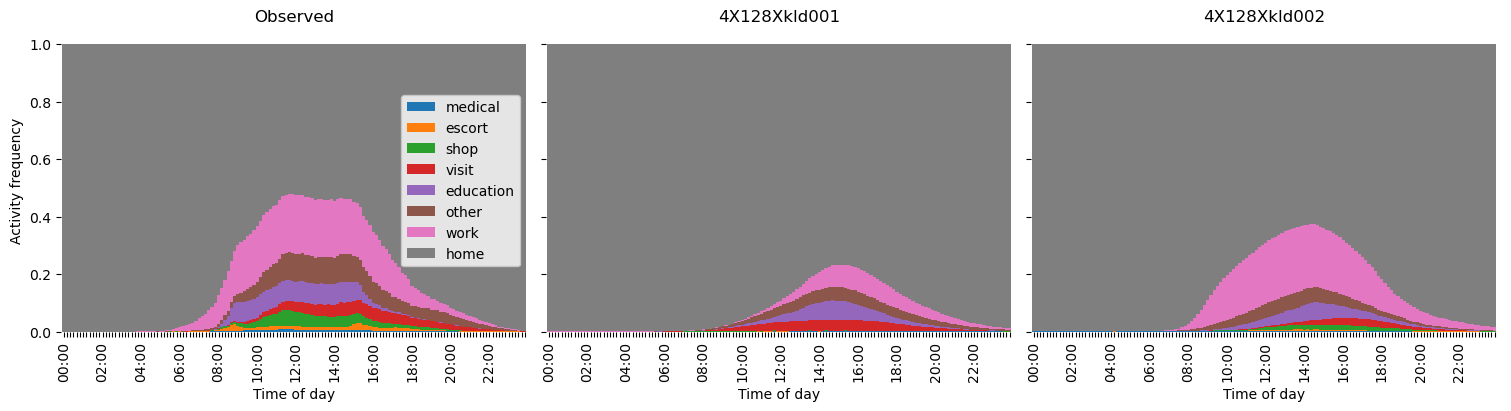

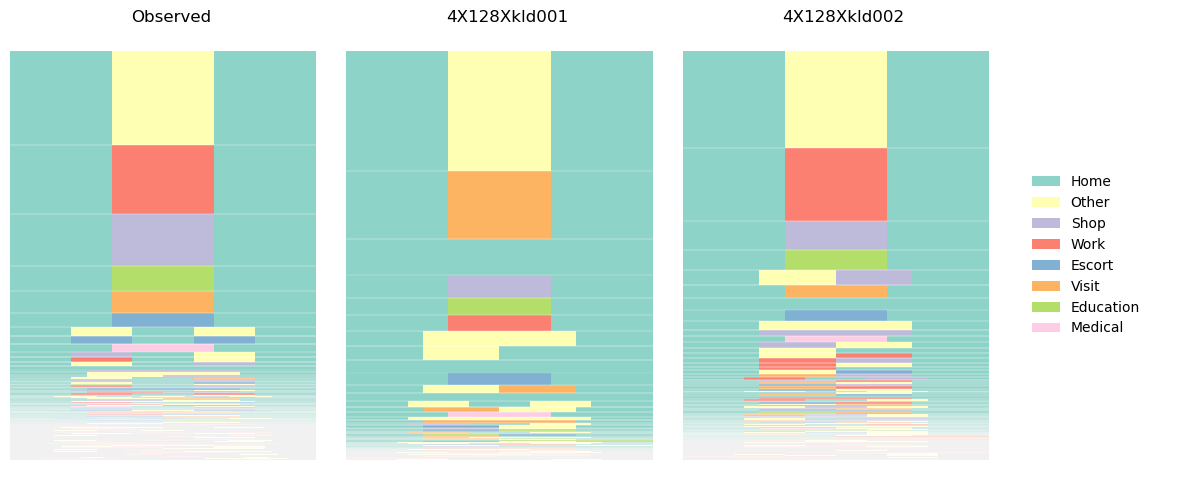

In [10]:
batch_path = Path("../logs/search_c_rnn_vae")
schedules = {
    n: pd.read_csv(p / "synthetic_schedules.csv")
    for n, p in iter_models(batch_path)
    if n.startswith("4")
}
fig = frequency.frequency_plots(target_schedules, schedules)
fig = transitions.sequence_prob_plot(target_schedules, schedules)

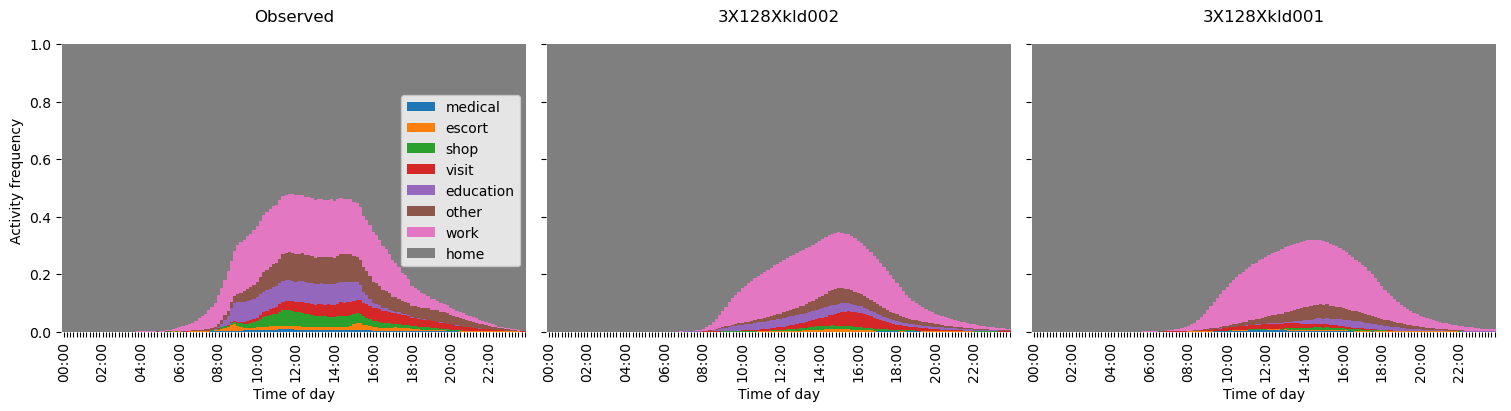

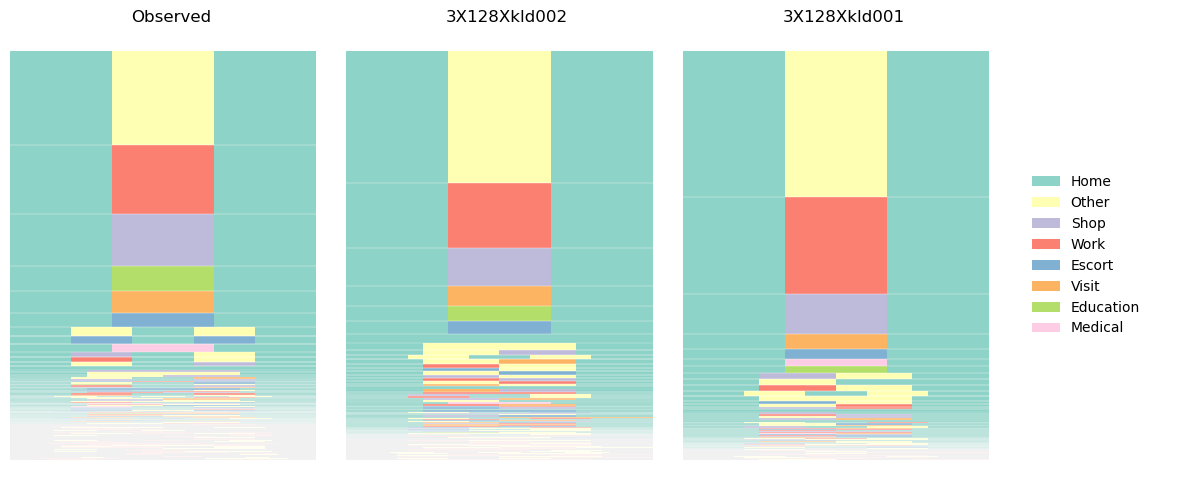

In [9]:
batch_path = Path("../logs/search_c_rnn_vae")
schedules = {
    n: pd.read_csv(p / "synthetic_schedules.csv")
    for n, p in iter_models(batch_path)
    if n.startswith("3")
}
fig = frequency.frequency_plots(target_schedules, schedules)
fig = transitions.sequence_prob_plot(target_schedules, schedules)

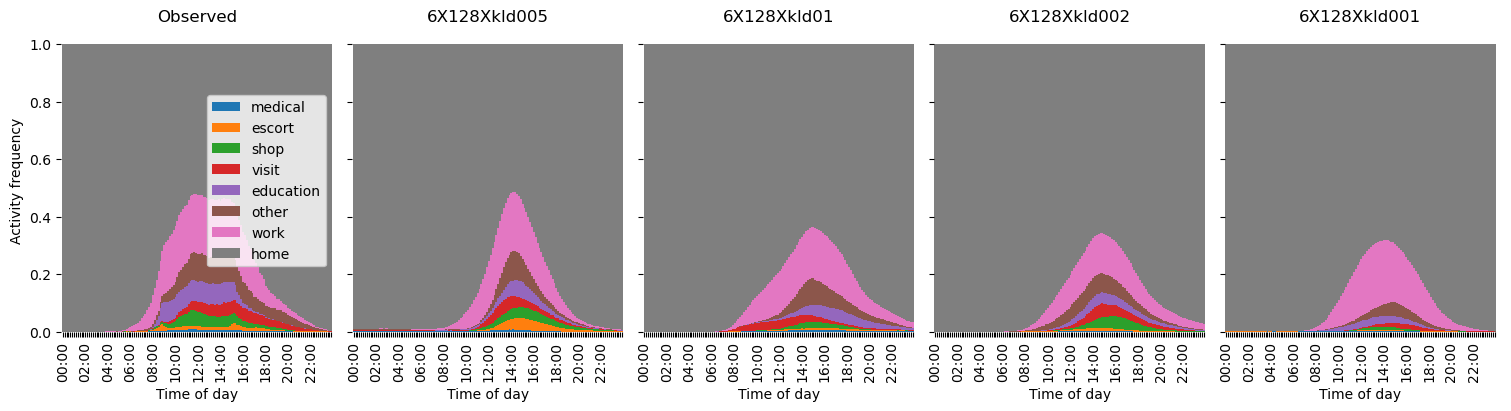

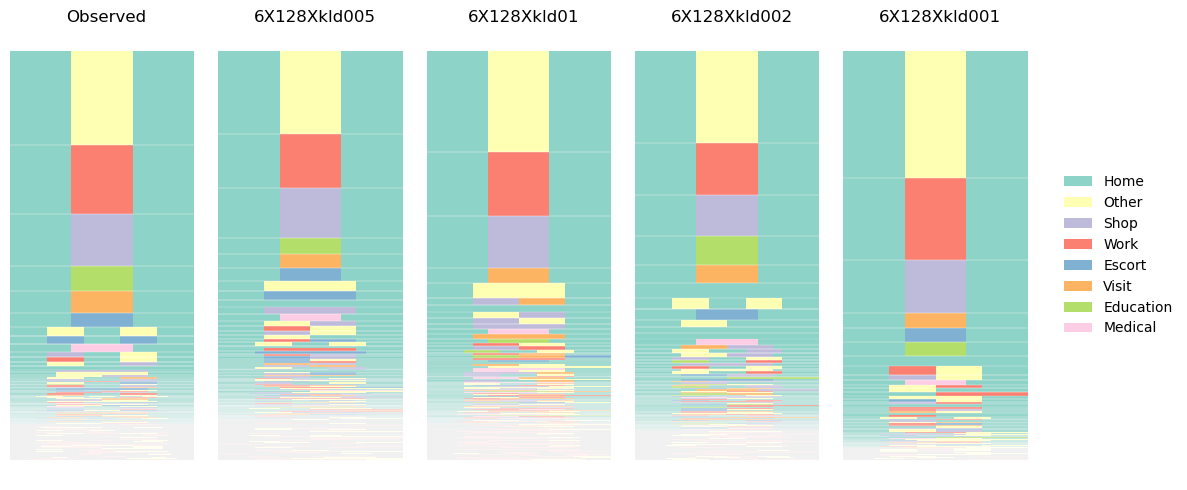

In [8]:
batch_path = Path("../logs/search_c_rnn_vae")
schedules = {
    n: pd.read_csv(p / "synthetic_schedules.csv")
    for n, p in iter_models(batch_path)
    if n.startswith("6")
}
fig = frequency.frequency_plots(target_schedules, schedules)
fig = transitions.sequence_prob_plot(target_schedules, schedules)

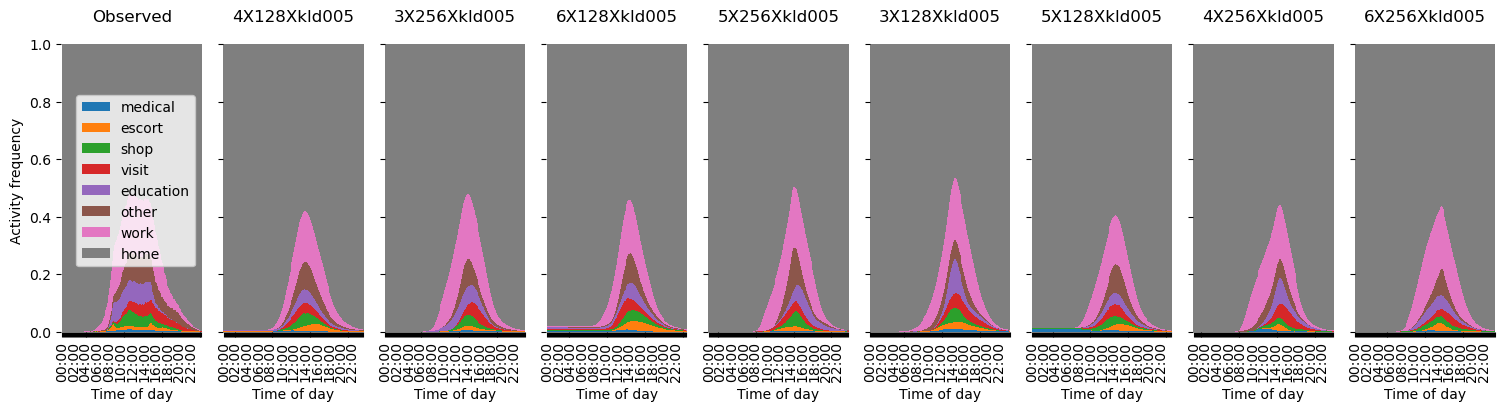

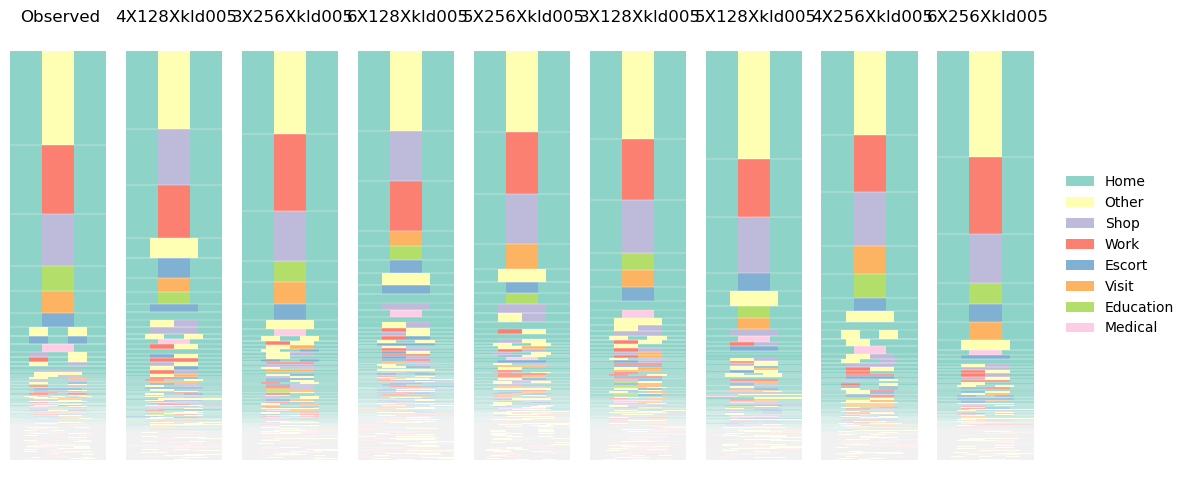

In [9]:
batch_path = Path("../logs/search_c_rnn_vae")
schedules = {
    n: pd.read_csv(p / "synthetic_schedules.csv")
    for n, p in iter_models(batch_path)
    if n.endswith("005")
}
fig = frequency.frequency_plots(target_schedules, schedules)
fig = transitions.sequence_prob_plot(target_schedules, schedules)

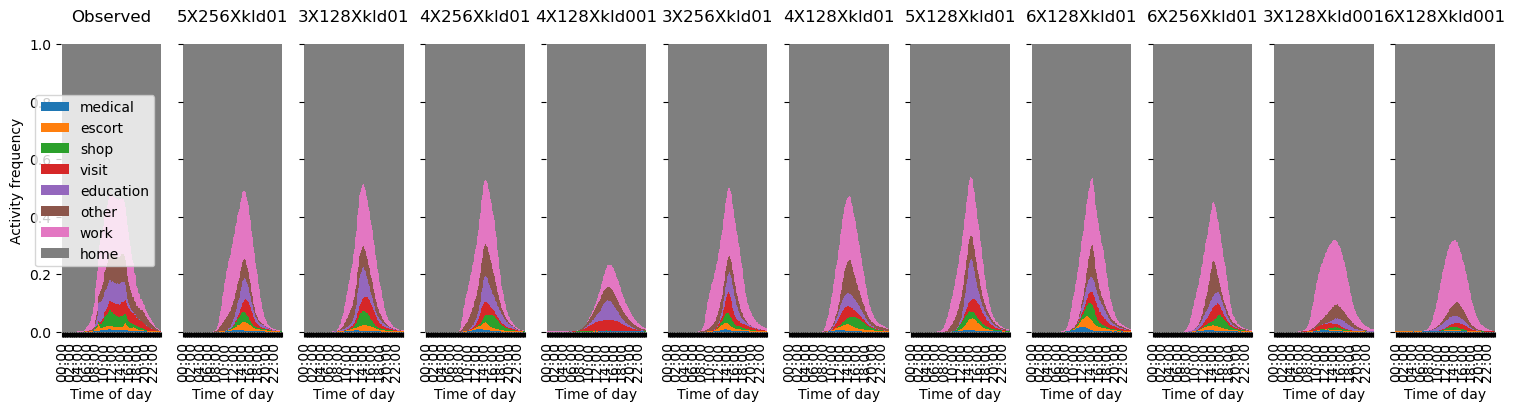

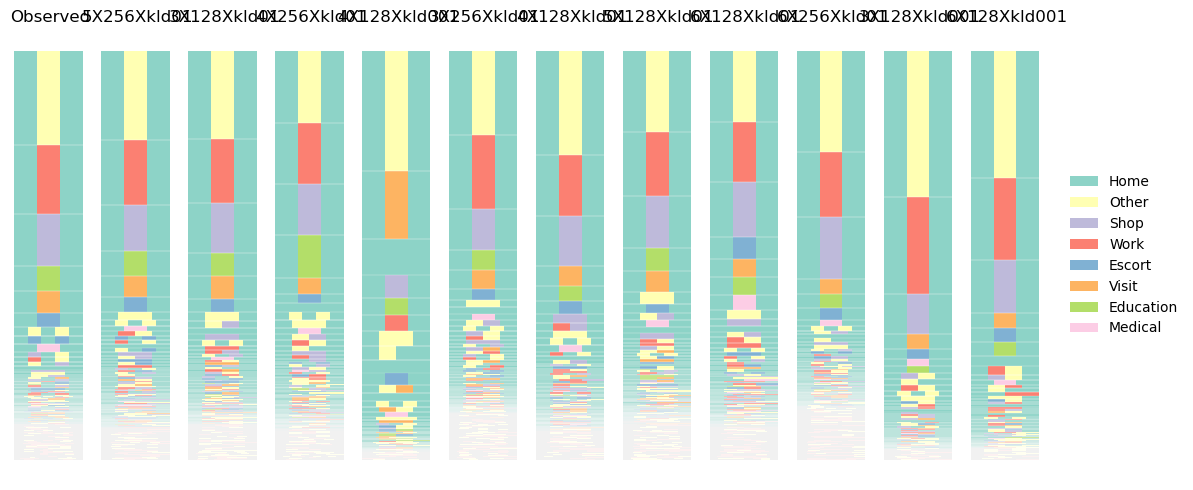

In [10]:
batch_path = Path("../logs/search_c_rnn_vae")
schedules = {
    n: pd.read_csv(p / "synthetic_schedules.csv")
    for n, p in iter_models(batch_path)
    if n.endswith("01")
}
fig = frequency.frequency_plots(target_schedules, schedules)
fig = transitions.sequence_prob_plot(target_schedules, schedules)

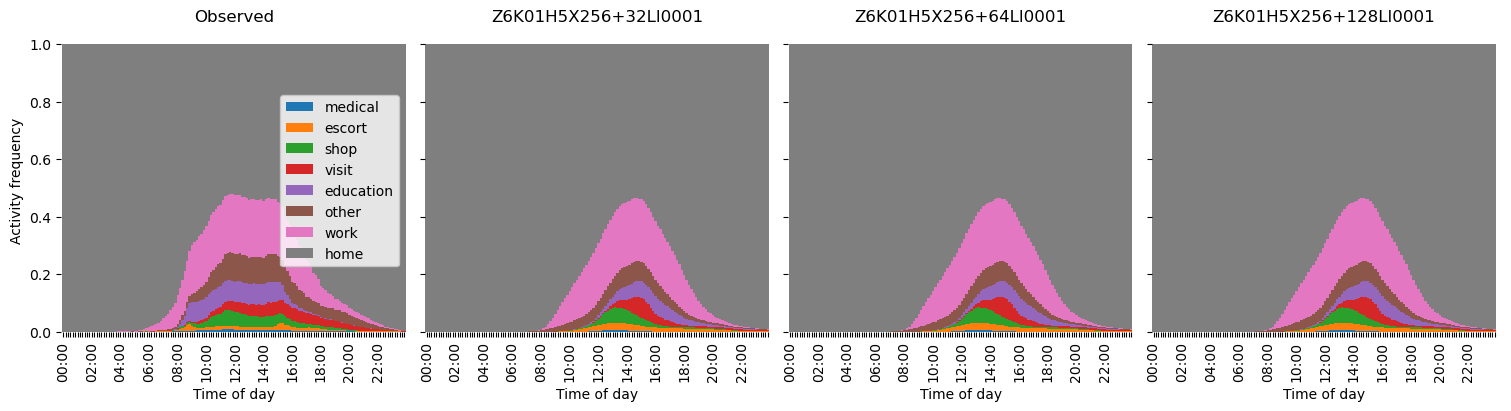

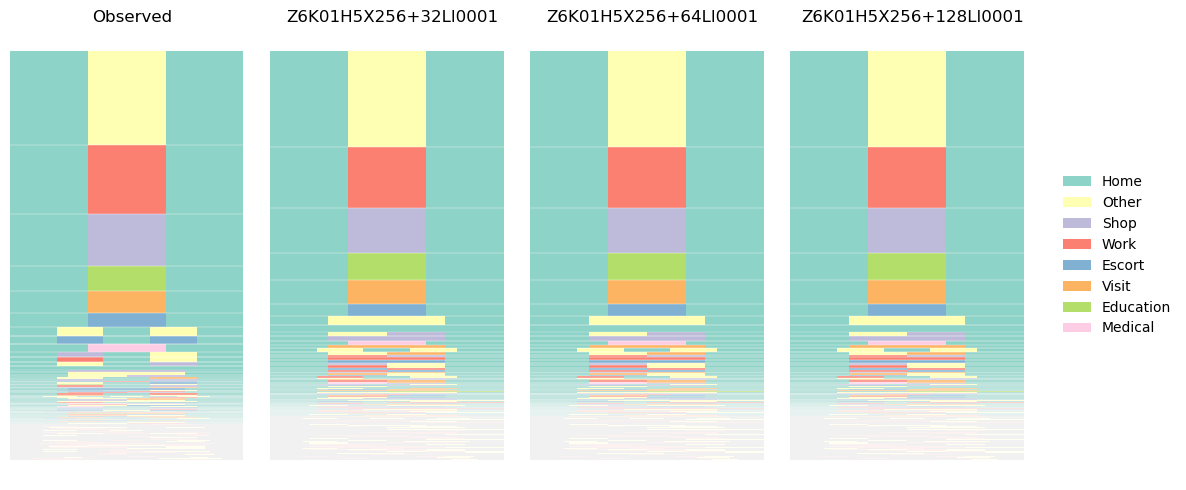

In [11]:
batch_path = Path("../logs/search_c_rnn_Jvae4")
schedules = {
    n: pd.read_csv(p / "synthetic_schedules.csv")
    for n, p in iter_models(batch_path)
    if n.endswith("LL0001")
}
fig = frequency.frequency_plots(target_schedules, schedules)
fig = transitions.sequence_prob_plot(target_schedules, schedules)

In [7]:
schedules = pd.read_csv("../tmp/nts_home_schedules.csv")
attributes = pd.read_csv("../tmp/nts_home_attributes_groups.csv")
schedules.pid.nunique()

37306

In [8]:
attributes.tail()

,Unnamed: 0,pid,age,gender,ethnicity,education,license,car_access,work_status,area,income,hh_size,hh_composition,hh_children,hh_cars,hh_bikes,hh_motorcycles,age_group
39845,39845,39845,11,F,white,unknown,unknown,yes,unemployed,urban,4,4,3+adult_1+child,1,2.0,4,0.0,11-16
39846,39846,39846,11,F,white,unknown,unknown,yes,unemployed,urban,4,4,3+adult_1+child,1,2.0,4,0.0,11-16
39847,39847,39847,30,F,white,Y,yes,yes,employed,urban,4,1,1adult,0,1.0,0,0.0,30-40
39848,39848,39848,30,F,white,Y,yes,yes,employed,urban,4,1,1adult,0,1.0,0,0.0,30-40
39849,39849,39849,30,F,white,Y,yes,yes,employed,urban,4,1,1adult,0,1.0,0,0.0,30-40


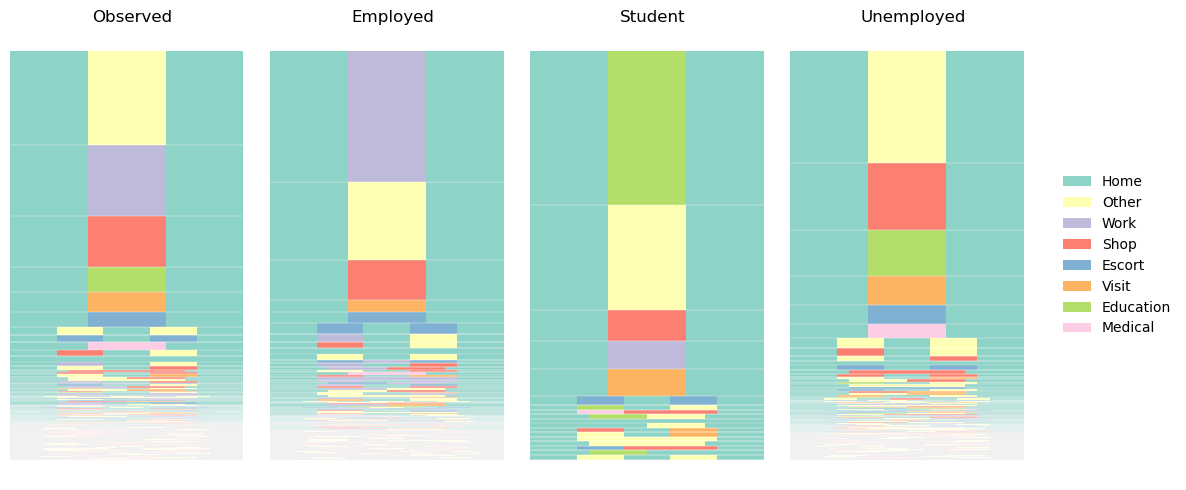

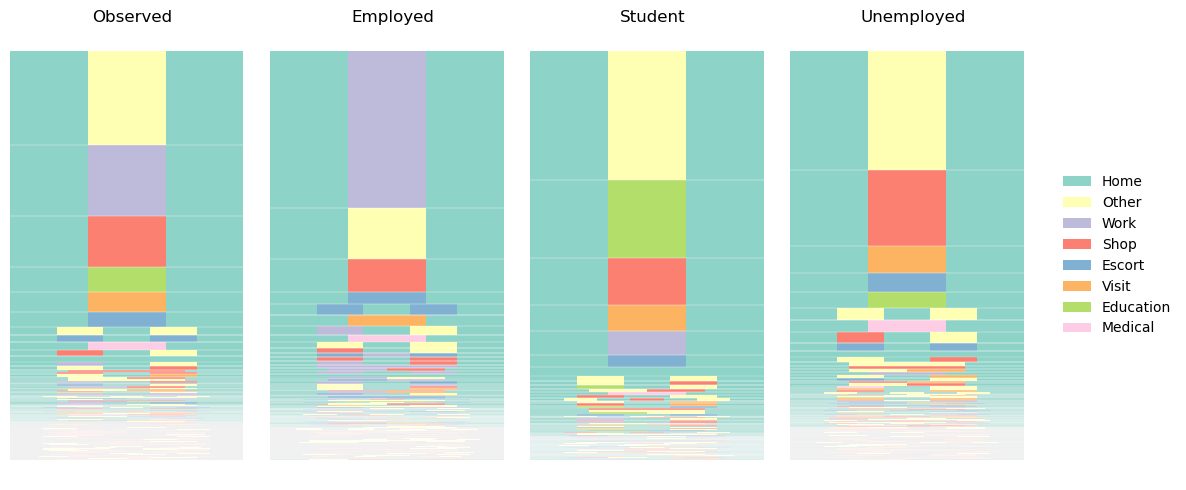

In [9]:
def split_on(schedules, attributes, by="work_status"):
    splits = attributes.groupby(by)
    return {
        k: schedules.loc[schedules.pid.isin(list(v.pid))] for k, v in splits
    }


# schedules = pd.read_csv("../tmp/nts_home_schedules.csv")
# attributes = pd.read_csv("../tmp/nts_home_attributes_groups.csv")
# splits = split_on(schedules, attributes)
# fig = transitions.sequence_prob_plot(schedules, splits)


schedules = pd.read_csv("../logs/label_model/version_14/input_schedules.csv")
labels = pd.read_csv("../logs/label_model/version_14/input_labels.csv")
preds = pd.read_csv("../logs/label_model/version_14/inferred_labels.csv")
splits = split_on(schedules, labels)
fig = transitions.sequence_prob_plot(schedules, splits)
splits = split_on(schedules, preds)
fig = transitions.sequence_prob_plot(schedules, splits)

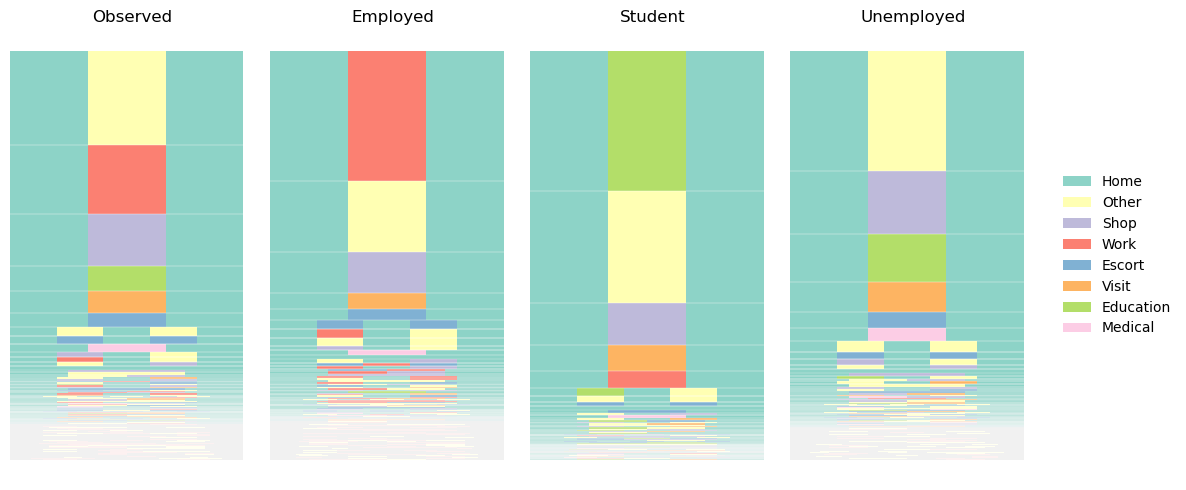

In [4]:
def split_on(schedules, attributes, by="work_status"):
    splits = attributes.groupby(by)
    return {
        k: schedules.loc[schedules.pid.isin(list(v.pid))] for k, v in splits
    }


schedules = pd.read_csv("../tmp/nts_home_schedules.csv")
attributes = pd.read_csv("../tmp/nts_home_attributes_groups.csv")
splits = split_on(schedules, attributes)
fig = transitions.sequence_prob_plot(schedules, splits)

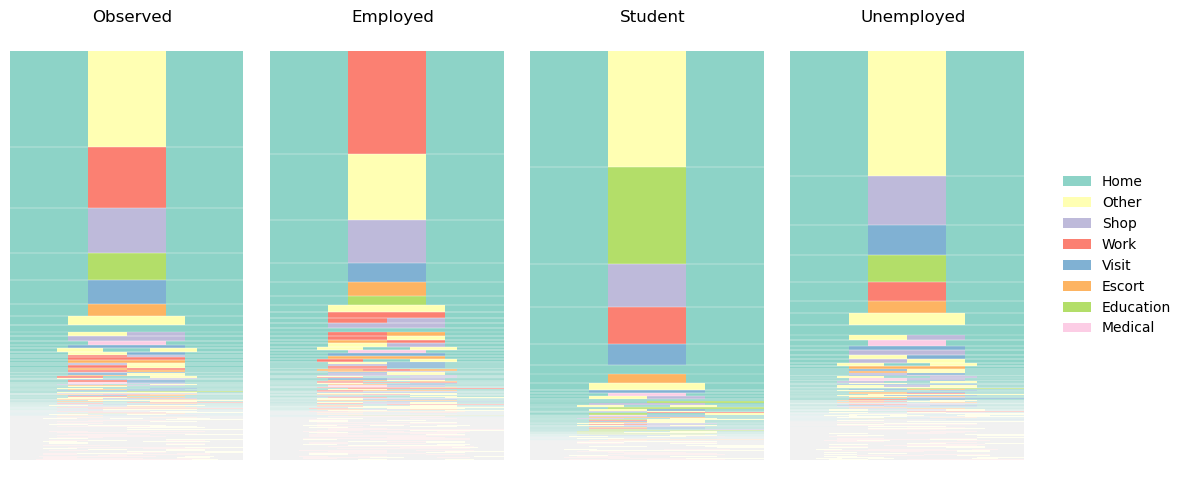

In [12]:
root = latest(Path("../logs/search_c_rnn_Jvae4/Z6K01H5x256+32LL0001"))[1]
schedules = pd.read_csv(root / "synthetic_schedules.csv")
schedules = schedules[schedules.act != "<MISSING>"]
attributes = pd.read_csv(root / "synthetic_labels.csv")
splits = split_on(schedules, attributes)
fig = transitions.sequence_prob_plot(schedules, splits)

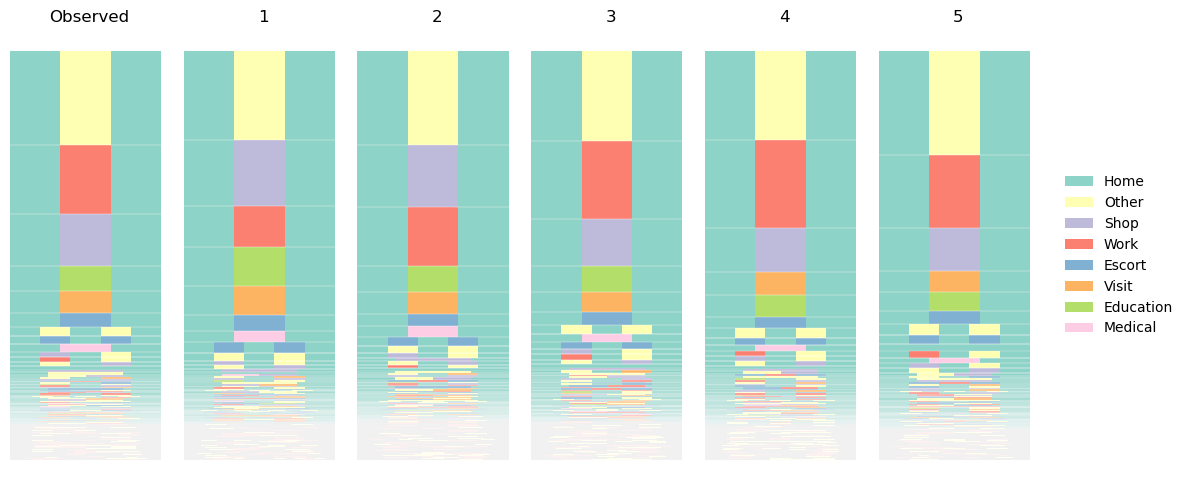

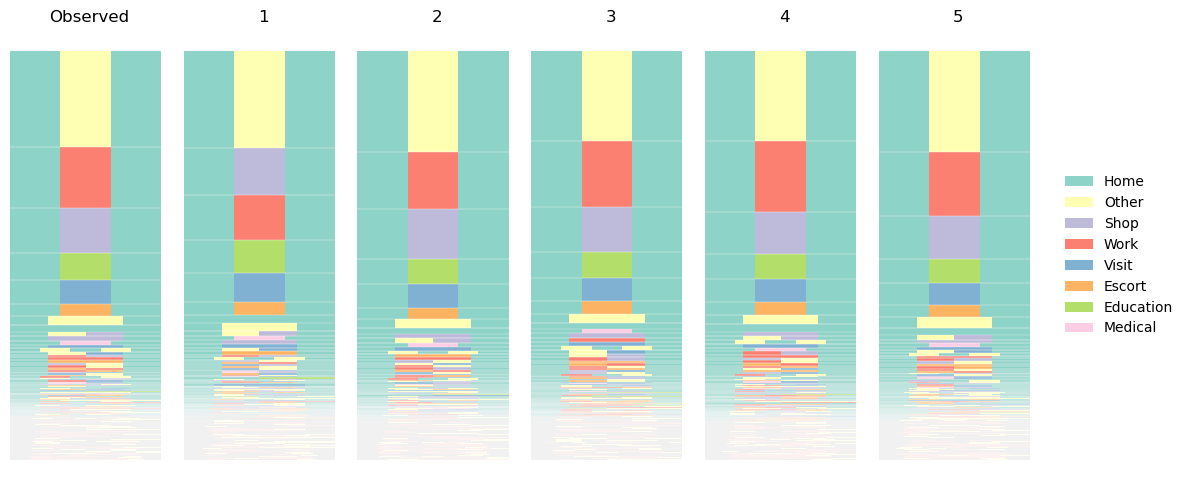

In [20]:
schedules = pd.read_csv("../tmp/nts_home_schedules.csv")
attributes = pd.read_csv("../tmp/nts_home_attributes_groups.csv")
attributes.income = attributes.income.astype(str)
splits = split_on(schedules, attributes, by="income")
fig = transitions.sequence_prob_plot(schedules, splits)

root = latest(Path("../logs/search_c_rnn_Jvae4/Z6K01H5x256+32LL0001"))[1]
schedules = pd.read_csv(root / "synthetic_schedules.csv")
schedules = schedules[schedules.act != "<MISSING>"]
attributes = pd.read_csv(root / "synthetic_labels.csv")
attributes.income = attributes.income.astype(str)
splits = split_on(schedules, attributes, by="income")
fig = transitions.sequence_prob_plot(schedules, splits)

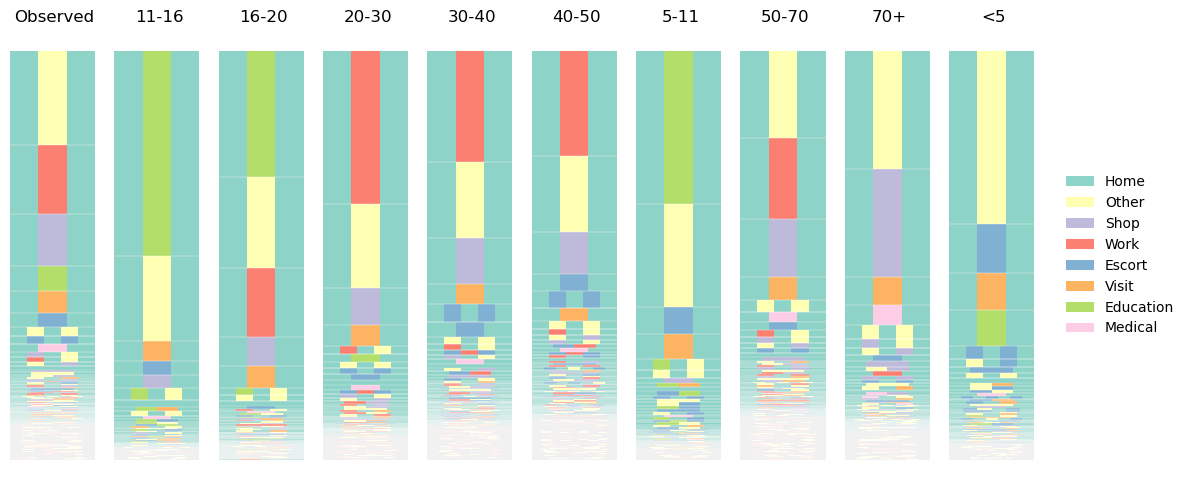

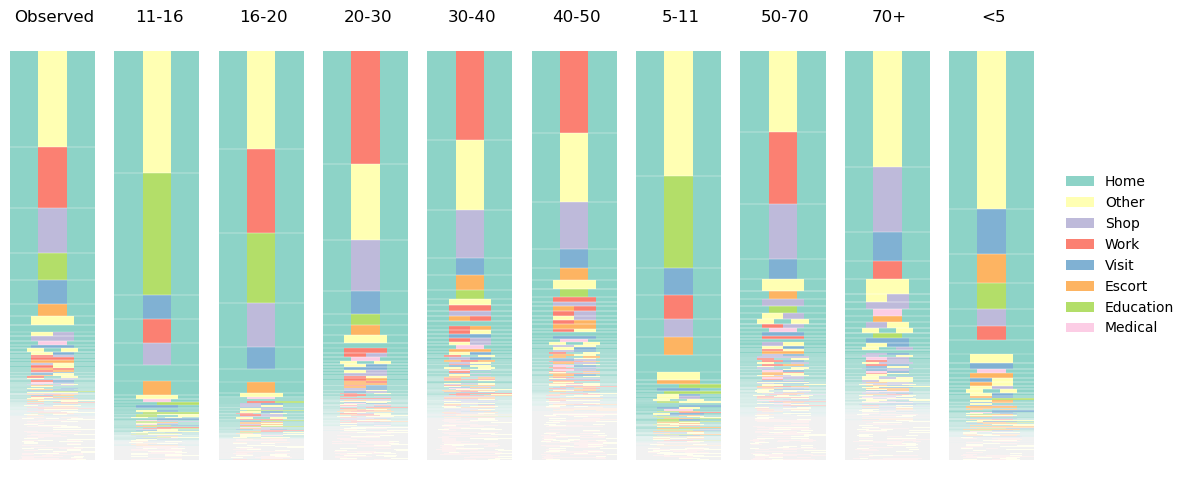

In [21]:
schedules = pd.read_csv("../tmp/nts_home_schedules.csv")
attributes = pd.read_csv("../tmp/nts_home_attributes_groups.csv")
attributes.age_group = attributes.age_group.astype(str)
splits = split_on(schedules, attributes, by="age_group")
fig = transitions.sequence_prob_plot(schedules, splits)

root = latest(Path("../logs/search_c_rnn_Jvae4/Z6K01H5x256+32LL0001"))[1]
schedules = pd.read_csv(root / "synthetic_schedules.csv")
schedules = schedules[schedules.act != "<MISSING>"]
attributes = pd.read_csv(root / "synthetic_labels.csv")
attributes.age_group = attributes.age_group.astype(str)
splits = split_on(schedules, attributes, by="age_group")
fig = transitions.sequence_prob_plot(schedules, splits)

In [5]:
def build_distance_tables(batch_paths, suffix=""):
    distances_combined = pd.DataFrame()

    for name, path in batch_paths.items():
        distances = pd.read_csv(
            path / f"domain_distances{suffix}.csv"
        ).set_index("domain")

        distances_combined[(name, "mean")] = distances.mean(axis=1)
        distances_combined[(name, "std")] = distances.std(axis=1)
    distances_combined = distances_combined.T

    distances_combined = distances_combined.set_index(
        pd.MultiIndex.from_tuples(distances_combined.index)
    )
    distances_combined = distances_combined.unstack(level=-1)
    distances_combined = distances_combined.drop("creativity", axis=1)
    sample_quality = distances_combined["sample quality"]
    density = distances_combined[
        ["aggregate", "participations", "transitions", "timing"]
    ]

    # creativity

    return (sample_quality, density)


batch_paths = {
    "Discrete RNN (Baseline)": Path("../logs/paper_d_rnn"),
    "Discrete CNN VAE": Path("../logs/paper_d_cnn_vae_2"),
    "Continuous RNN VAE": Path("../logs/paper_c_rnn_vae"),
    "Continuous RNN JVAE": Path("../logs/paper_c_rnn_Jvae"),
}


sample_quality, density = build_distance_tables(batch_paths)

In [6]:
print(sample_quality[::-1].to_latex(float_format="{:.3f}".format))

\begin{tabular}{lrr}
\toprule
 & mean & std \\
\midrule
Discrete RNN (Baseline) & 0.125 & 0.354 \\
Discrete CNN VAE & 0.167 & 0.408 \\
Continuous RNN VAE & 0.253 & 0.366 \\
Continuous RNN JVAE & 0.243 & 0.371 \\
\bottomrule
\end{tabular}



In [8]:
sample_quality_cond, density_cond = build_distance_tables(
    batch_paths, suffix="_subs"
)
print(sample_quality_cond[::-1].to_latex(float_format="{:.3f}".format))

\begin{tabular}{lrr}
\toprule
 & mean & std \\
\midrule
Discrete RNN (Baseline) & 0.167 & 0.408 \\
Discrete CNN VAE & 0.167 & 0.408 \\
Continuous RNN VAE & 0.253 & 0.366 \\
Continuous RNN JVAE & 0.245 & 0.370 \\
\bottomrule
\end{tabular}



In [16]:
print(density.loc[::-1].to_latex(float_format="{:.3f}".format))
density.loc[::-1]

\begin{tabular}{lrrrrrrrr}
\toprule
domain & \multicolumn{2}{r}{aggregate} & \multicolumn{2}{r}{participations} & \multicolumn{2}{r}{transitions} & \multicolumn{2}{r}{timing} \\
 & mean & std & mean & std & mean & std & mean & std \\
\midrule
Discrete RNN (Baseline) & 0.175 & 0.211 & 1.415 & 0.532 & 0.062 & 0.029 & 0.197 & 0.140 \\
Discrete CNN VAE & 0.140 & 0.269 & 0.436 & 0.408 & 0.015 & 0.005 & 0.136 & 0.186 \\
Continuous RNN VAE & 0.138 & 0.270 & 0.313 & 0.469 & 0.015 & 0.004 & 0.153 & 0.177 \\
Continuous RNN JVAE & 0.134 & 0.272 & 0.321 & 0.465 & 0.015 & 0.005 & 0.152 & 0.177 \\
\bottomrule
\end{tabular}



domain                  aggregate           participations            \
                             mean       std           mean       std   
Discrete RNN (Baseline)  0.174966  0.211181       1.415020  0.531742   
Discrete CNN VAE         0.140207  0.268812       0.435759  0.408144   
Continuous RNN VAE       0.137666  0.270059       0.313265  0.468511   
Continuous RNN JVAE      0.134230  0.271738       0.320660  0.465403   

domain                  transitions              timing            
                               mean       std      mean       std  
Discrete RNN (Baseline)    0.061509  0.028780  0.196807  0.140088  
Discrete CNN VAE           0.015026  0.004548  0.135607  0.185519  
Continuous RNN VAE         0.015496  0.004291  0.152844  0.177147  
Continuous RNN JVAE        0.014708  0.005266  0.152136  0.177413

In [13]:
density_cond

domain                  aggregate           participations            \
                             mean       std           mean       std   
Continuous RNN JVAE      0.136120  0.266914       0.320310  0.454897   
Continuous RNN VAE       0.138646  0.265697       0.323451  0.453164   
Discrete CNN VAE         0.139067  0.265486       0.469060  0.382203   
Discrete RNN (Baseline)  0.213583  0.229107       1.480680  0.368655   

domain                  transitions              timing            
                               mean       std      mean       std  
Continuous RNN JVAE        0.025686  0.006183  0.157871  0.176853  
Continuous RNN VAE         0.026482  0.005589  0.157294  0.177198  
Discrete CNN VAE           0.027617  0.004578  0.141067  0.185086  
Discrete RNN (Baseline)    0.077363  0.020923  0.238863  0.137887

In [14]:
print(density_cond.loc[::-1].to_latex(float_format="{:.3f}".format))

\begin{tabular}{lrrrrrrrr}
\toprule
domain & \multicolumn{2}{r}{aggregate} & \multicolumn{2}{r}{participations} & \multicolumn{2}{r}{transitions} & \multicolumn{2}{r}{timing} \\
 & mean & std & mean & std & mean & std & mean & std \\
\midrule
Discrete RNN (Baseline) & 0.214 & 0.229 & 1.481 & 0.369 & 0.077 & 0.021 & 0.239 & 0.138 \\
Discrete CNN VAE & 0.139 & 0.265 & 0.469 & 0.382 & 0.028 & 0.005 & 0.141 & 0.185 \\
Continuous RNN VAE & 0.139 & 0.266 & 0.323 & 0.453 & 0.026 & 0.006 & 0.157 & 0.177 \\
Continuous RNN JVAE & 0.136 & 0.267 & 0.320 & 0.455 & 0.026 & 0.006 & 0.158 & 0.177 \\
\bottomrule
\end{tabular}



In [5]:
def build_description_tables(batch_paths, suffix=""):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(
            path / f"feature_descriptions{suffix}.csv"
        ).set_index(["domain", "feature"])
        columns = set(descriptions.columns)
        columns = list(columns - set(["observed", "description"]))
        # print(descriptions)

        descriptions_combined[(name, "mean")] = descriptions[columns].mean(
            axis=1
        )
        descriptions_combined[(name, "std")] = descriptions[columns].std(axis=1)

    # print(descriptions_combined)

    descriptions_combined = descriptions_combined.T
    descriptions_combined = descriptions_combined.set_index(
        pd.MultiIndex.from_tuples(descriptions_combined.index)
    )
    descriptions_combined = descriptions_combined.unstack(level=-1)

    observed = []
    descs = descriptions["observed"]
    for o in descs:
        observed.append(o)
        observed.append(0)

    descriptions_combined.loc["Observed"] = observed

    creativity = descriptions_combined["creativity"]
    sample_quality = descriptions_combined["sample quality"]
    density = descriptions_combined[
        ["aggregate", "participations", "transitions", "timing"]
    ]

    # creativity

    return (creativity, sample_quality, density)


batch_paths = {
    "Discrete RNN (Baseline)": Path("../logs/paper_d_rnn"),
    "Discrete CNN VAE": Path("../logs/paper_d_cnn_vae_2"),
    "Continuous RNN VAE": Path("../logs/paper_c_rnn_vae"),
    "Continuous RNN JVAE": Path("../logs/paper_c_rnn_Jvae"),
}


creativity, sample_quality, density = build_description_tables(batch_paths)

In [7]:
print(creativity.loc[::-1, :].to_latex(float_format="{:.3f}".format))
creativity.loc[::-1, :]

\begin{tabular}{lrrrr}
\toprule
feature & \multicolumn{2}{r}{diversity} & \multicolumn{2}{r}{novelty} \\
 & mean & std & mean & std \\
\midrule
Observed & 0.550 & 0.000 & 1.000 & 0.000 \\
Discrete RNN (Baseline) & 0.007 & 0.003 & 0.857 & 0.378 \\
Discrete CNN VAE & 0.755 & 0.006 & 0.955 & 0.004 \\
Continuous RNN VAE & 0.990 & 0.003 & 1.000 & 0.000 \\
Continuous RNN JVAE & 0.997 & 0.004 & 1.000 & 0.000 \\
\bottomrule
\end{tabular}



feature                 diversity             novelty          
                             mean       std      mean       std
Observed                 0.549724  0.000000  1.000000  0.000000
Discrete RNN (Baseline)  0.007076  0.003082  0.857143  0.377964
Discrete CNN VAE         0.754619  0.006473  0.954638  0.004077
Continuous RNN VAE       0.990455  0.003482  0.999940  0.000030
Continuous RNN JVAE      0.997334  0.003566  0.999977  0.000038

In [8]:
print(sample_quality.loc[::-1, :].to_latex(float_format="{:.3f}".format))
sample_quality.loc[::-1, :]

\begin{tabular}{lrrrr}
\toprule
feature & \multicolumn{2}{r}{duration} & \multicolumn{2}{r}{home based} \\
 & mean & std & mean & std \\
\midrule
Observed & 1.000 & 0.000 & 1.000 & 0.000 \\
Discrete RNN (Baseline) & 0.857 & 0.378 & 0.857 & 0.378 \\
Discrete CNN VAE & 1.000 & 0.000 & 0.999 & 0.000 \\
Continuous RNN VAE & 0.904 & 0.020 & 0.943 & 0.024 \\
Continuous RNN JVAE & 0.905 & 0.033 & 0.945 & 0.024 \\
\bottomrule
\end{tabular}



feature                  duration           home based          
                             mean       std       mean       std
Observed                 1.000000  0.000000   1.000000  0.000000
Discrete RNN (Baseline)  0.857143  0.377964   0.857063  0.377830
Discrete CNN VAE         1.000000  0.000000   0.999493  0.000189
Continuous RNN VAE       0.903768  0.020147   0.942647  0.024045
Continuous RNN JVAE      0.904676  0.033251   0.945162  0.024425

In [116]:
def build_feature_description_tables(batch_paths):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(path / "feature_descriptions.csv").set_index(
            ["domain", "feature"]
        )
        columns = set(descriptions.columns)
        columns = list(
            columns - set(["observed", "description", "mean", "std"])
        )

        descriptions_combined[name] = descriptions[columns].mean(axis=1)

    descriptions_combined["Observed"] = descriptions["observed"]
    descriptions_combined["Description"] = descriptions["description"]

    order = list(descriptions_combined.columns)
    order.pop(order.index("Observed"))
    order = ["Observed"] + order

    index = [
        "creativity",
        "sample quality",
        "aggregate",
        "participations",
        "transitions",
        "timing",
    ]

    return descriptions_combined.loc[index, order]


batch_paths = {
    "Discrete RNN (Baseline)": Path("../logs/paper_d_rnn"),
    "Discrete CNN VAE": Path("../logs/paper_d_cnn_vae_2"),
    "Continuous RNN VAE": Path("../logs/paper_c_rnn_vae"),
    "Continuous RNN JVAE": Path("../logs/paper_c_rnn_Jvae"),
}

table = build_feature_description_tables(batch_paths)
table

Observed  Discrete RNN (Baseline)  \
domain         feature                                                      
creativity     diversity                   0.550                    0.008   
               novelty                     1.000                    1.000   
sample quality duration                    1.000                    1.000   
               home based                  1.000                    1.000   
aggregate      agg. frequency              0.689                    0.414   
participations lengths                     3.680                    8.252   
               pair participation rate     0.039                    0.118   
               participation rate          0.086                    0.192   
transitions    2-gram                      0.042                    0.113   
               3-gram                      0.005                    0.011   
timing         durations                   0.272                    0.155   
               end times                   0.684                    0.587   
               start times                 0.412                    0.432   
               start-durations             0.689                    0.635   

                                        Discrete CNN VAE  Continuous RNN VAE  \
domain         feature                                                         
creativity     diversity                           0.755               0.990   
               novelty                             0.955               1.000   
sample quality duration                            1.000               0.904   
               home based                          0.999               0.943   
aggregate      agg. frequency                      0.576               0.700   
participations lengths                             4.440               3.475   
               pair participation rate             0.046               0.033   
               participation rate                  0.103               0.081   
transitions    2-gram                              0.054               0.039   
               3-gram                              0.007               0.005   
timing         durations                           0.243               0.259   
               end times                           0.665               0.713   
               start times                         0.421               0.454   
               start-durations                     0.673               0.696   

                                        Continuous RNN JVAE    Description  
domain         feature                                                      
creativity     diversity                              0.997   prob. unique  
               novelty                                1.000    prob. novel  
sample quality duration                               0.905       duration  
               home based                             0.945          prob.  
aggregate      agg. frequency                         0.717  average freq.  
participations lengths                                3.377          prob.  
               pair participation rate                0.030       av rate.  
               participation rate                     0.079       av. rate  
transitions    2-gram                                 0.037       av. rate  
               3-gram                                 0.004       av. rate  
timing         durations                              0.265        average  
               end times                              0.694        average  
               start times                            0.429        average  
               start-durations                        0.683        average

In [117]:
print(table.to_latex(float_format="{:.3f}".format))

\begin{tabular}{llrrrrrl}
\toprule
 &  & Observed & Discrete RNN (Baseline) & Discrete CNN VAE & Continuous RNN VAE & Continuous RNN JVAE & Description \\
domain & feature &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{creativity} & diversity & 0.550 & 0.008 & 0.755 & 0.990 & 0.997 & prob. unique \\
 & novelty & 1.000 & 1.000 & 0.955 & 1.000 & 1.000 & prob. novel \\
\cline{1-8}
\multirow[t]{2}{*}{sample quality} & duration & 1.000 & 1.000 & 1.000 & 0.904 & 0.905 & duration \\
 & home based & 1.000 & 1.000 & 0.999 & 0.943 & 0.945 & prob. \\
\cline{1-8}
aggregate & agg. frequency & 0.689 & 0.414 & 0.576 & 0.700 & 0.717 & average freq. \\
\cline{1-8}
\multirow[t]{3}{*}{participations} & lengths & 3.680 & 8.252 & 4.440 & 3.475 & 3.377 & prob. \\
 & pair participation rate & 0.039 & 0.118 & 0.046 & 0.033 & 0.030 & av rate. \\
 & participation rate & 0.086 & 0.192 & 0.103 & 0.081 & 0.079 & av. rate \\
\cline{1-8}
\multirow[t]{2}{*}{transitions} & 2-gram & 0.042 & 0.113 & 0.054 & 0.039 & 0.

In [135]:
def build_all_description_tables(batch_paths):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(path / "descriptions.csv").set_index(
            ["domain", "feature", "segment"]
        )
        columns = set(descriptions.columns)
        columns = list(
            columns
            - set(["observed", "description", "mean", "std", "feature count"])
        )

        descriptions_combined[name] = descriptions[columns].mean(axis=1)

    descriptions_combined["Observed"] = descriptions["observed"]
    descriptions_combined["Description"] = descriptions["description"]

    descriptions_combined = (
        descriptions_combined.sort_values("Observed", ascending=False)
        .groupby(["domain", "feature"])
        .head(10)
    )

    order = list(descriptions_combined.columns)
    order.pop(order.index("Observed"))
    order = ["Observed"] + order

    index = [
        "creativity",
        "sample quality",
        "aggregate",
        "participations",
        "transitions",
        "timing",
    ]

    return descriptions_combined.loc[index, order]


batch_paths = {
    "Discrete RNN (Baseline)": Path("../logs/paper_d_rnn"),
    "Discrete CNN VAE": Path("../logs/paper_d_cnn_vae_2"),
    "Continuous RNN VAE": Path("../logs/paper_c_rnn_vae"),
    "Continuous RNN JVAE": Path("../logs/paper_c_rnn_Jvae"),
}

table = build_all_description_tables(batch_paths)
table

Observed  Discrete RNN (Baseline)  \
domain         feature    segment                                             
creativity     novelty    all                1.000                    1.000   
               diversity  all                0.550                    0.008   
sample quality duration   total duration     1.000                    1.000   
               home based last act home      1.000                    1.000   
                          first act home     1.000                    1.000   
...                                            ...                      ...   
timing         durations  home3              0.215                    0.000   
                          home6              0.196                    0.000   
                          education2         0.176                    0.075   
                          home4              0.166                    0.000   
                          home5              0.157                    0.000   

                                          Discrete CNN VAE  \
domain         feature    segment                            
creativity     novelty    all                        0.955   
               diversity  all                        0.755   
sample quality duration   total duration             1.000   
               home based last act home              0.999   
                          first act home             1.000   
...                                                    ...   
timing         durations  home3                      0.186   
                          home6                      0.154   
                          education2                 0.051   
                          home4                      0.176   
                          home5                      0.170   

                                          Continuous RNN VAE  \
domain         feature    segment                              
creativity     novelty    all                          1.000   
               diversity  all                          0.990   
sample quality duration   total duration               0.904   
               home based last act home                0.912   
                          first act home               0.973   
...                                                      ...   
timing         durations  home3                        0.114   
                          home6                        0.000   
                          education2                   0.073   
                          home4                        0.000   
                          home5                        0.000   

                                          Continuous RNN JVAE   Description  
domain         feature    segment                                            
creativity     novelty    all                           1.000   prob. novel  
               diversity  all                           0.997  prob. unique  
sample quality duration   total duration                0.905      duration  
               home based last act home                 0.931         prob.  
                          first act home                0.959         prob.  
...                                                       ...           ...  
timing         durations  home3                         0.120       average  
                          home6                         0.000       average  
                          education2                    0.040       average  
                          home4                         0.026       average  
                          home5                         0.000       average  

[92 rows x 6 columns]

In [156]:
for domain in [
    "creativity",
    "sample quality",
    "aggregate",
    "participations",
    "transitions",
    "timing",
]:
    print()
    print(domain)
    print()
    ss = table.loc[domain]
    for feature in set(ss.reset_index()["feature"]):
        print(feature)
        print()
        print(ss.loc[feature].to_latex(float_format="{:.3f}".format))


creativity

novelty

\begin{tabular}{lrrrrrl}
\toprule
 & Observed & Discrete RNN (Baseline) & Discrete CNN VAE & Continuous RNN VAE & Continuous RNN JVAE & Description \\
segment &  &  &  &  &  &  \\
\midrule
all & 1.000 & 1.000 & 0.955 & 1.000 & 1.000 & prob. novel \\
\bottomrule
\end{tabular}

diversity

\begin{tabular}{lrrrrrl}
\toprule
 & Observed & Discrete RNN (Baseline) & Discrete CNN VAE & Continuous RNN VAE & Continuous RNN JVAE & Description \\
segment &  &  &  &  &  &  \\
\midrule
all & 0.550 & 0.008 & 0.755 & 0.990 & 0.997 & prob. unique \\
\bottomrule
\end{tabular}


sample quality

home based

\begin{tabular}{lrrrrrl}
\toprule
 & Observed & Discrete RNN (Baseline) & Discrete CNN VAE & Continuous RNN VAE & Continuous RNN JVAE & Description \\
segment &  &  &  &  &  &  \\
\midrule
last act home & 1.000 & 1.000 & 0.999 & 0.912 & 0.931 & prob. \\
first act home & 1.000 & 1.000 & 1.000 & 0.973 & 0.959 & prob. \\
\bottomrule
\end{tabular}

duration

\begin{tabular}{lrrrrrl}
\

In [18]:
def build_subs_description_tables(batch_paths):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(path / "descriptions_subs.csv").set_index(
            ["domain", "feature", "segment", "sub_pop"]
        )
        columns = set(descriptions.columns)
        columns = list(
            columns
            - set(["observed", "description", "mean", "std", "feature count"])
        )

        descriptions_combined[name] = descriptions[columns].mean(axis=1)

    descriptions_combined["Observed"] = descriptions["observed"]
    descriptions_combined["Description"] = descriptions["description"]

    descriptions_combined = (
        descriptions_combined.sort_values("Observed", ascending=False)
        .groupby(["domain", "feature", "sub_pop"])
        .head(100)
    )

    order = list(descriptions_combined.columns)
    order.pop(order.index("Observed"))
    order = ["Observed"] + order

    index = [
        "creativity",
        "sample quality",
        "aggregate",
        "participations",
        "transitions",
        "timing",
    ]

    return descriptions_combined.loc[index, order]


batch_paths = {
    "Discrete RNN (Baseline)": Path("../logs/paper_d_rnn"),
    "Discrete CNN VAE": Path("../logs/paper_d_cnn_vae_2"),
    "Continuous RNN VAE": Path("../logs/paper_c_rnn_vae"),
    "Continuous RNN JVAE": Path("../logs/paper_c_rnn_Jvae"),
}

table = build_subs_description_tables(batch_paths)
table

Observed  \
domain     feature     segment    sub_pop                          
creativity novelty     all        age_group=5-11             1.0   
                                  gender=F                   1.0   
                                  work_status=employed       1.0   
                                  car_access=no              1.0   
                                  age_group=50-70            1.0   
...                                                          ...   
timing     durations   education2 income=3                   NaN   
                       education3 income=3                   NaN   
           start times education3 income=2                   NaN   
           end times   education3 income=2                   NaN   
           durations   education3 income=2                   NaN   

                                                        Discrete RNN (Baseline)  \
domain     feature     segment    sub_pop                                         
creativity novelty     all        age_group=5-11                       1.000000   
                                  gender=F                             1.000000   
                                  work_status=employed                 1.000000   
                                  car_access=no                        1.000000   
                                  age_group=50-70                      1.000000   
...                                                                         ...   
timing     durations   education2 income=3                             0.052423   
                       education3 income=3                             0.023611   
           start times education3 income=2                             0.101389   
           end times   education3 income=2                             0.125000   
           durations   education3 income=2                             0.023611   

                                                        Discrete CNN VAE  \
domain     feature     segment    sub_pop                                  
creativity novelty     all        age_group=5-11                0.988326   
                                  gender=F                      0.958274   
                                  work_status=employed          0.959561   
                                  car_access=no                 0.979751   
                                  age_group=50-70               0.966764   
...                                                                  ...   
timing     durations   education2 income=3                      0.049232   
                       education3 income=3                      0.033963   
           start times education3 income=2                      0.578272   
           end times   education3 income=2                      0.620378   
           durations   education3 income=2                      0.042106   

                                                        Continuous RNN VAE  \
domain     feature     segment    sub_pop                                    
creativity novelty     all        age_group=5-11                  1.000000   
                                  gender=F                        0.999947   
                                  work_status=employed            0.999960   
                                  car_access=no                   1.000000   
                                  age_group=50-70                 1.000000   
...                                                                    ...   
timing     durations   education2 income=3                        0.038194   
                       education3 income=3                             NaN   
           start times education3 income=2                             NaN   
           end times   education3 income=2                             NaN   
           durations   education3 income=2                             NaN   

                                                        Continuous RNN JVAE  \
domain  

In [19]:
table.loc[
    "participations",
    "participation rate",
    "work0",
    ["work_status=student", "work_status=employed"],
]

Observed  \
domain         feature            segment sub_pop                          
participations participation rate work0   work_status=student   0.052345   
                                          work_status=employed  0.443468   

                                                                Discrete RNN (Baseline)  \
domain         feature            segment sub_pop                                         
participations participation rate work0   work_status=student                  0.528858   
                                          work_status=employed                 0.778701   

                                                                Discrete CNN VAE  \
domain         feature            segment sub_pop                                  
participations participation rate work0   work_status=student           0.290889   
                                          work_status=employed          0.300520   

                                                                Continuous RNN VAE  \
domain         feature            segment sub_pop                                    
participations participation rate work0   work_status=student             0.247966   
                                          work_status=employed            0.234522   

                                                                Continuous RNN JVAE  \
domain         feature            segment sub_pop                                     
participations participation rate work0   work_status=student              0.173552   
                                          work_status=employed             0.161535   

                                                               Description  
domain         feature            segment sub_pop                           
participations participation rate work0   work_status=student     av. rate  
                                          work_status=employed    av. rate

In [20]:
table.loc[
    "participations",
    "participation rate",
    "education0",
    ["work_status=student", "work_status=employed"],
]

Observed  \
domain         feature            segment    sub_pop                          
participations participation rate education0 work_status=student   0.384951   
                                             work_status=employed  0.004419   

                                                                   Discrete RNN (Baseline)  \
domain         feature            segment    sub_pop                                         
participations participation rate education0 work_status=student                  0.865531   
                                             work_status=employed                 0.880671   

                                                                   Discrete CNN VAE  \
domain         feature            segment    sub_pop                                  
participations participation rate education0 work_status=student           0.101518   
                                             work_status=employed          0.100390   

                                                                   Continuous RNN VAE  \
domain         feature            segment    sub_pop                                    
participations participation rate education0 work_status=student             0.066828   
                                             work_status=employed            0.073071   

                                                                   Continuous RNN JVAE  \
domain         feature            segment    sub_pop                                     
participations participation rate education0 work_status=student              0.103340   
                                             work_status=employed             0.103733   

                                                                  Description  
domain         feature            segment    sub_pop                           
participations participation rate education0 work_status=student     av. rate  
                                             work_status=employed    av. rate

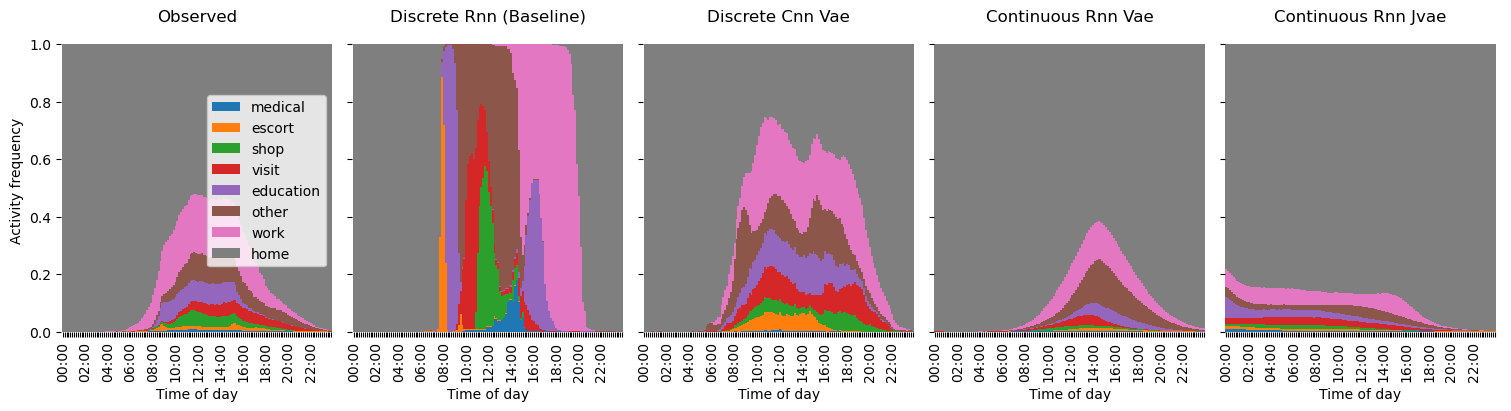

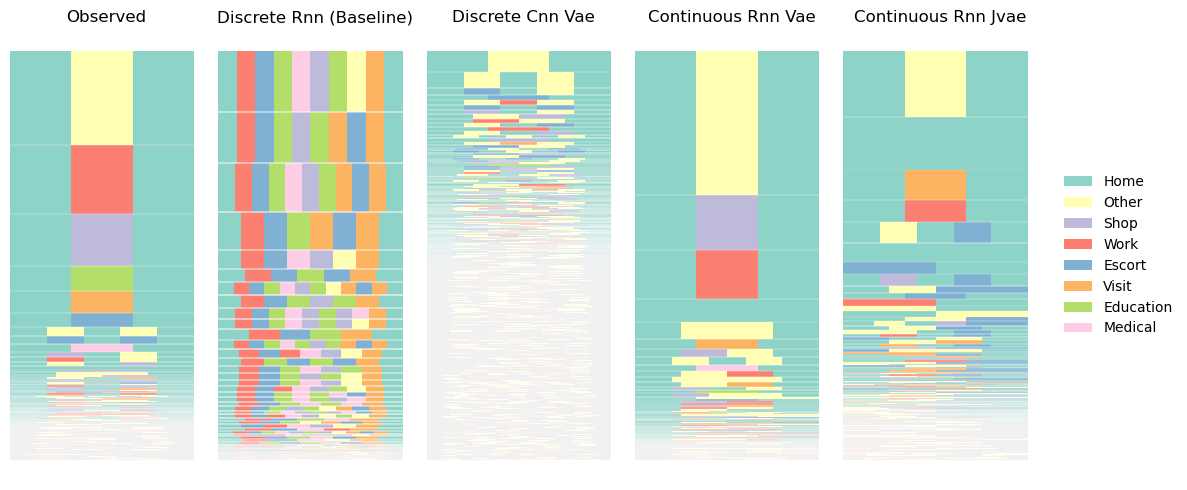

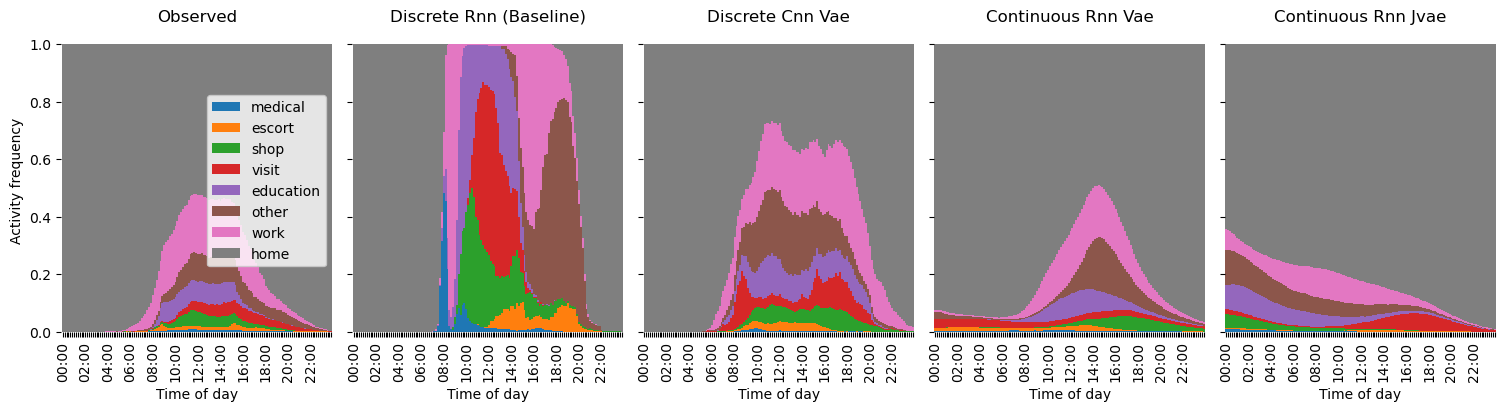

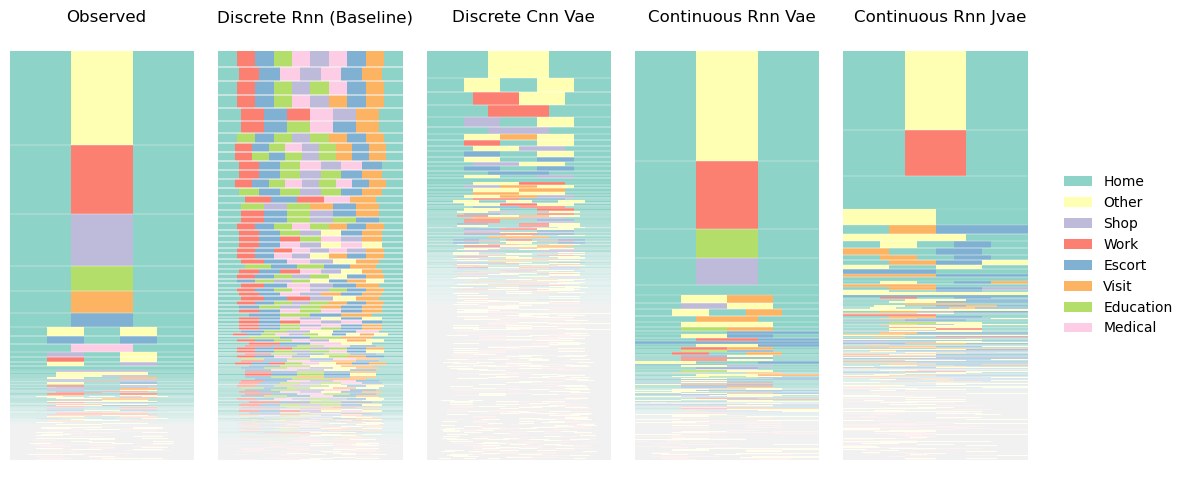

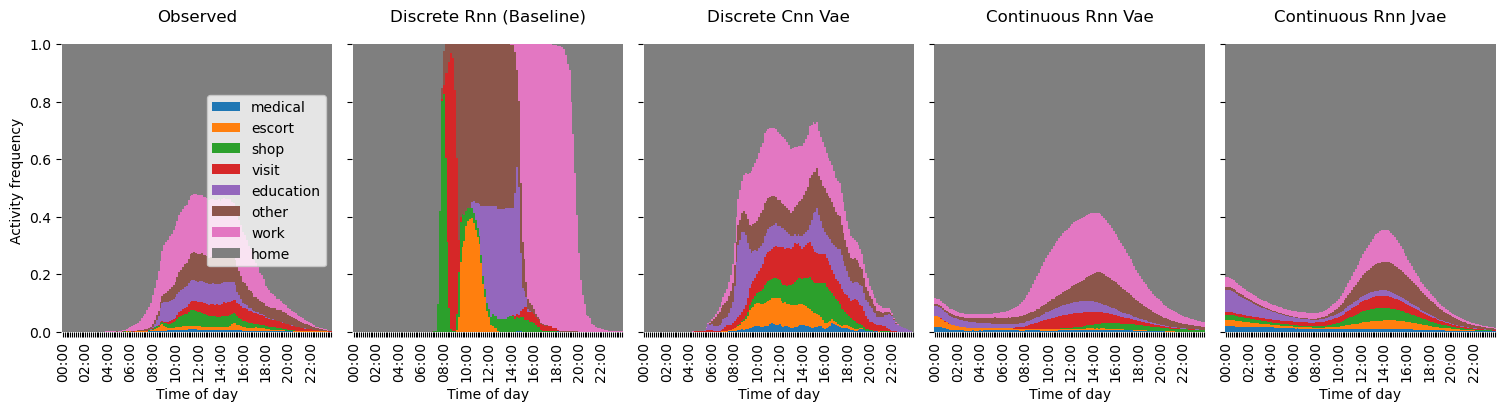

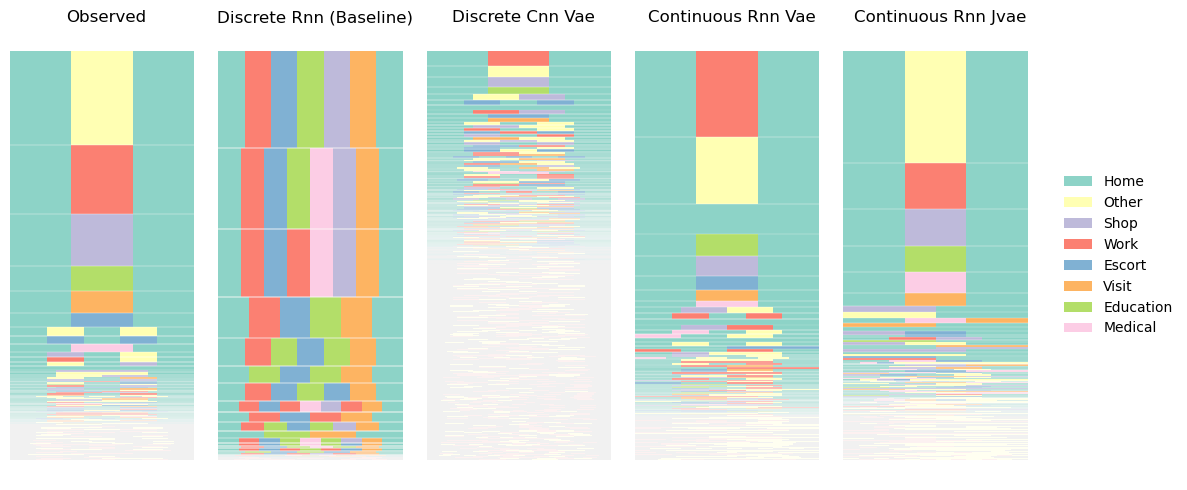

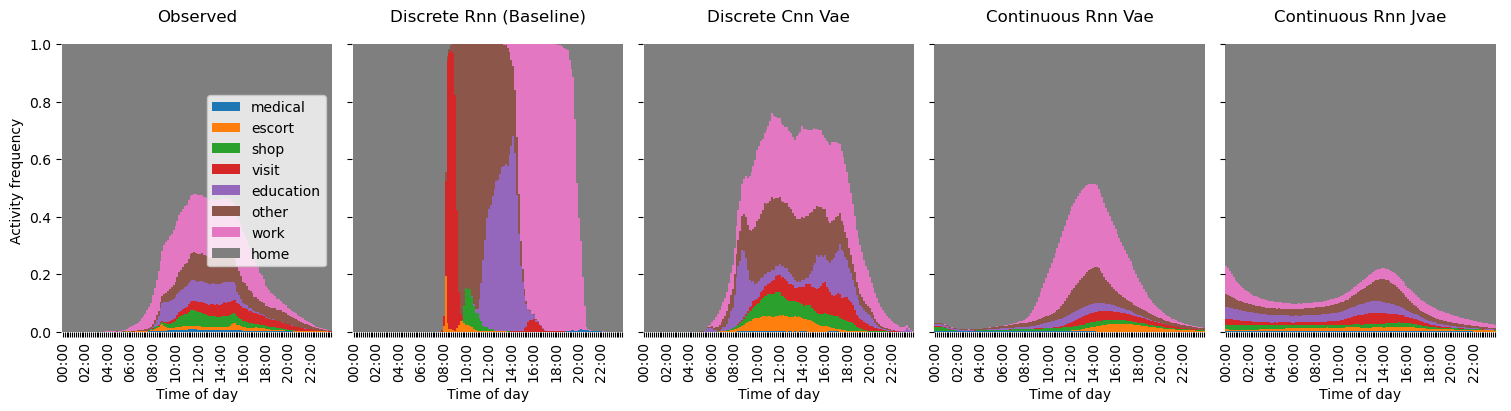

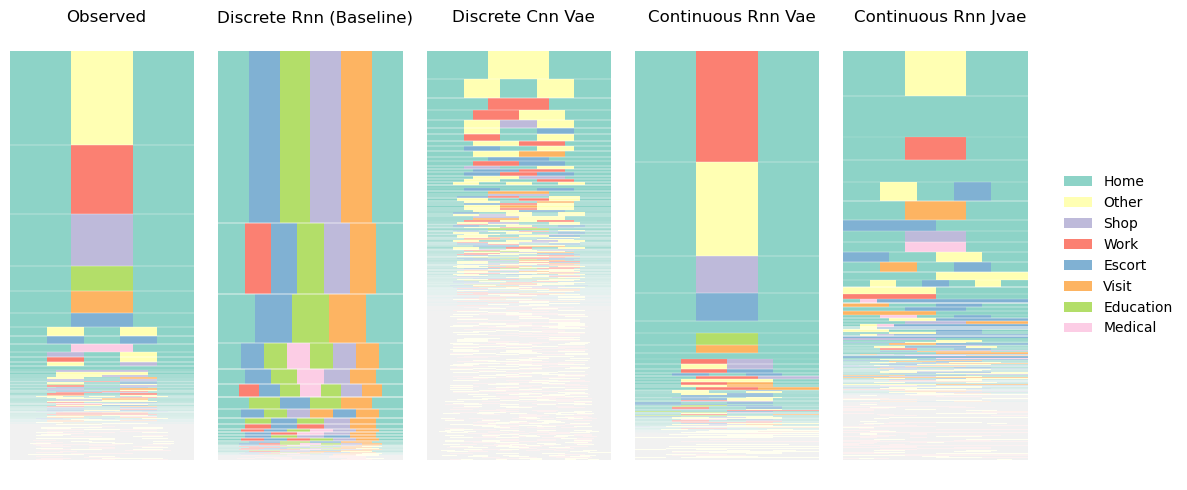

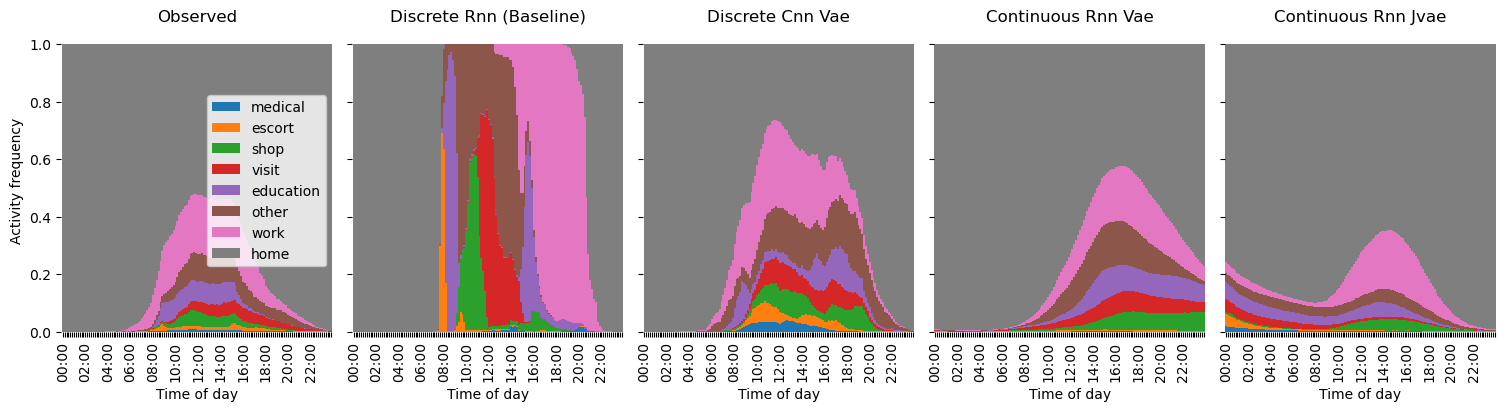

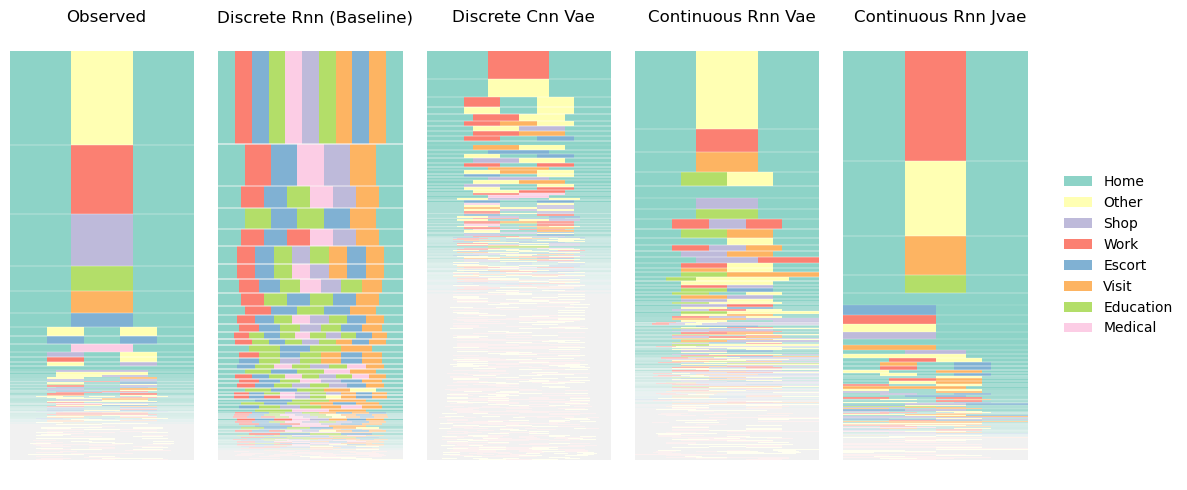

In [24]:
for i in range(5):
    schedules = {
        k: pd.read_csv(list(iter_models(v))[i] / "synthetic_schedules.csv")
        for k, v in batch_paths.items()
    }
    fig = frequency.frequency_plots(target_schedules, schedules)
    fig = transitions.sequence_prob_plot(target_schedules, schedules)

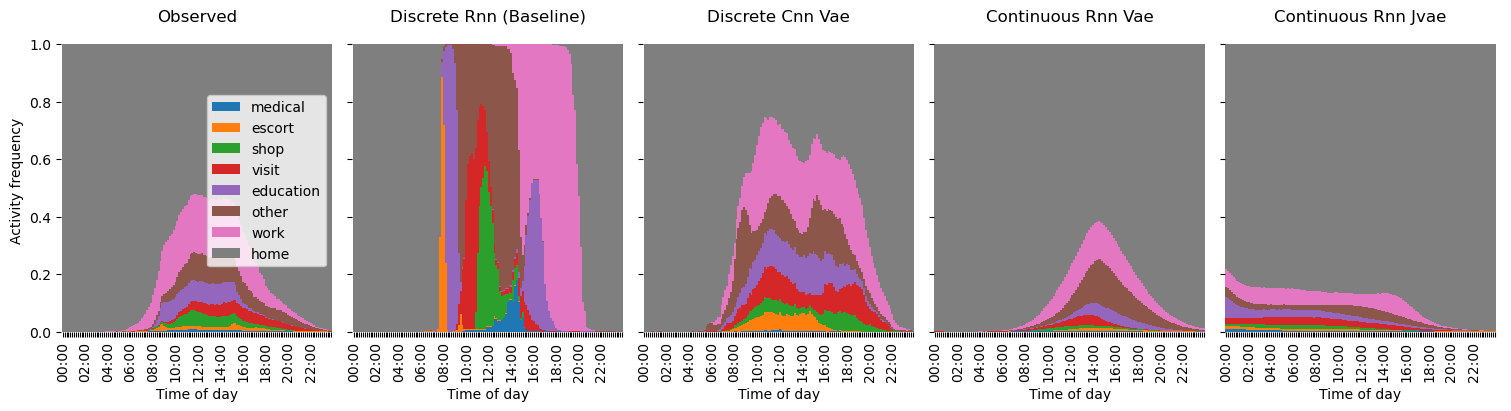

In [17]:
# freq plots
# fig, axs = plt.subplots(5, 1, figsize=(5, 12))
# frequency.plot_agg_acts("NTS", target_schedules, class_map, ax=axs[0])
schedules = {
    k: pd.read_csv(list(iter_models(v))[0] / "synthetic_schedules.csv")
    for k, v in batch_paths.items()
}
fig = frequency.frequency_plots(target_schedules, schedules)

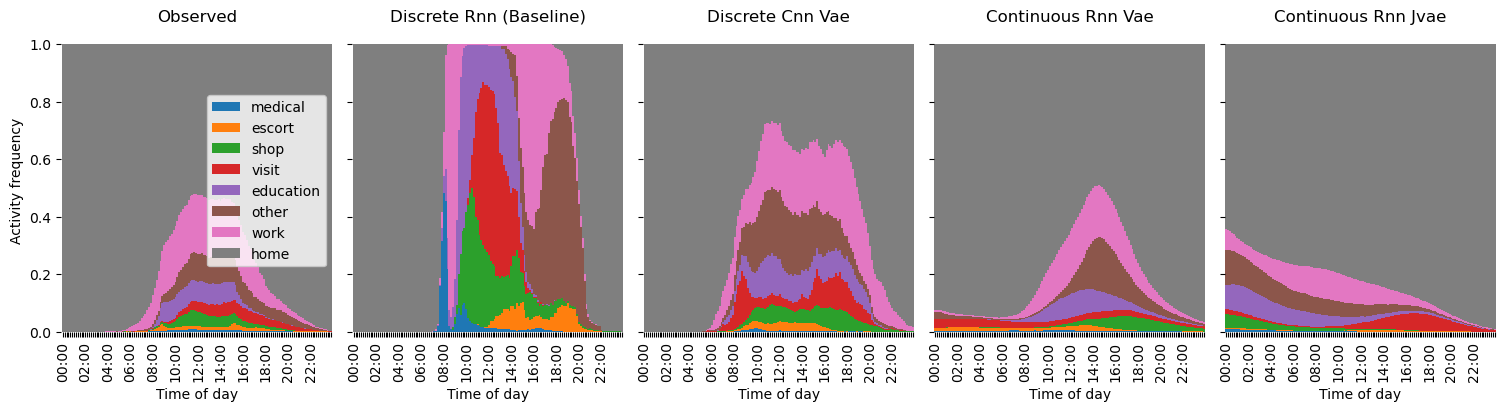

In [18]:
# freq plots
# fig, axs = plt.subplots(5, 1, figsize=(5, 12))
# frequency.plot_agg_acts("NTS", target_schedules, class_map, ax=axs[0])
schedules = {
    k: pd.read_csv(list(iter_models(v))[1] / "synthetic_schedules.csv")
    for k, v in batch_paths.items()
}
fig = frequency.frequency_plots(target_schedules, schedules)

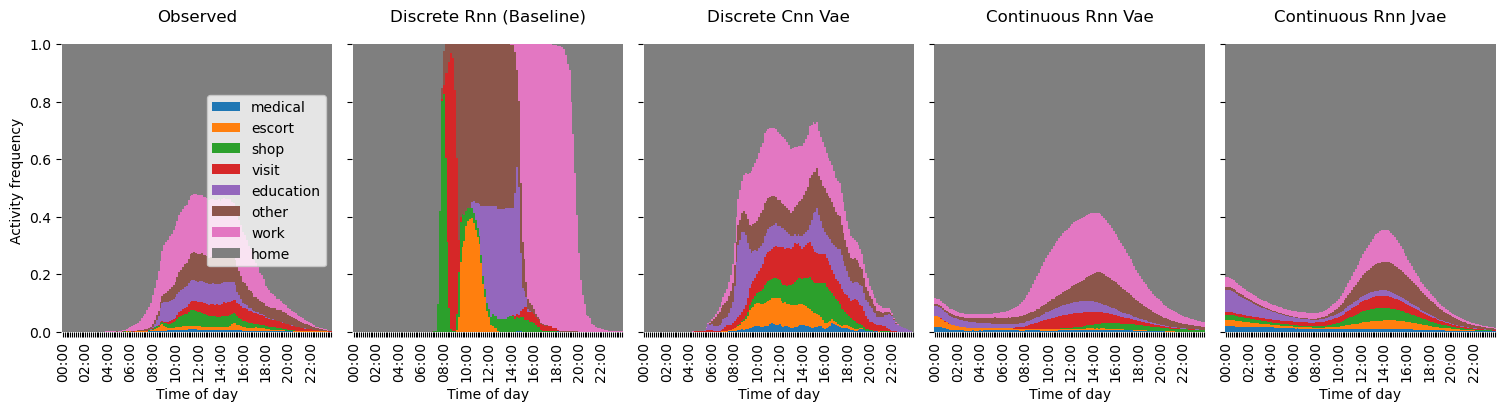

In [19]:
# freq plots
# fig, axs = plt.subplots(5, 1, figsize=(5, 12))
# frequency.plot_agg_acts("NTS", target_schedules, class_map, ax=axs[0])
schedules = {
    k: pd.read_csv(list(iter_models(v))[2] / "synthetic_schedules.csv")
    for k, v in batch_paths.items()
}
fig = frequency.frequency_plots(target_schedules, schedules)

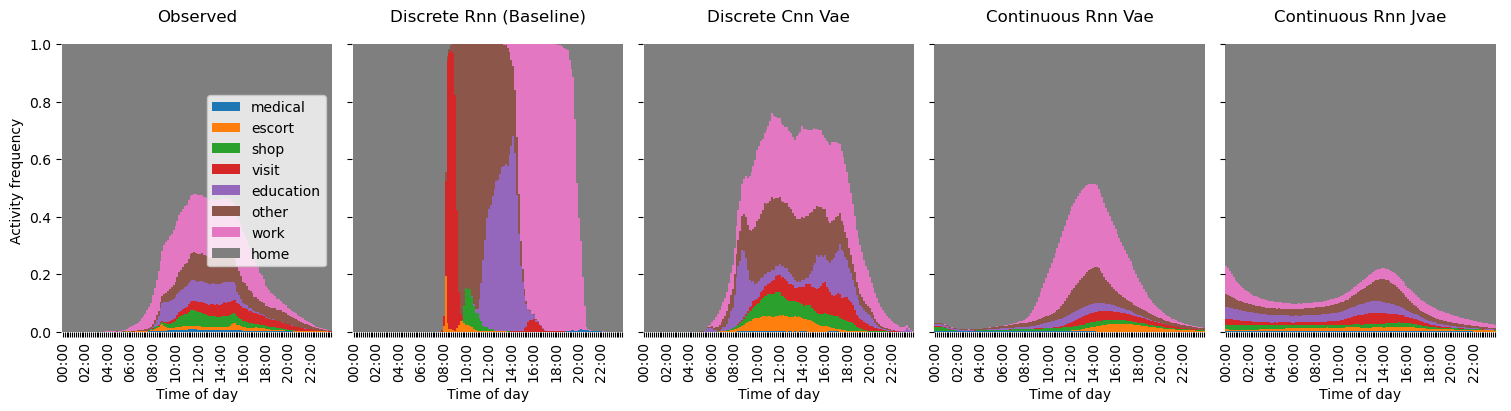

In [20]:
# freq plots
# fig, axs = plt.subplots(5, 1, figsize=(5, 12))
# frequency.plot_agg_acts("NTS", target_schedules, class_map, ax=axs[0])
schedules = {
    k: pd.read_csv(list(iter_models(v))[3] / "synthetic_schedules.csv")
    for k, v in batch_paths.items()
}
fig = frequency.frequency_plots(target_schedules, schedules)

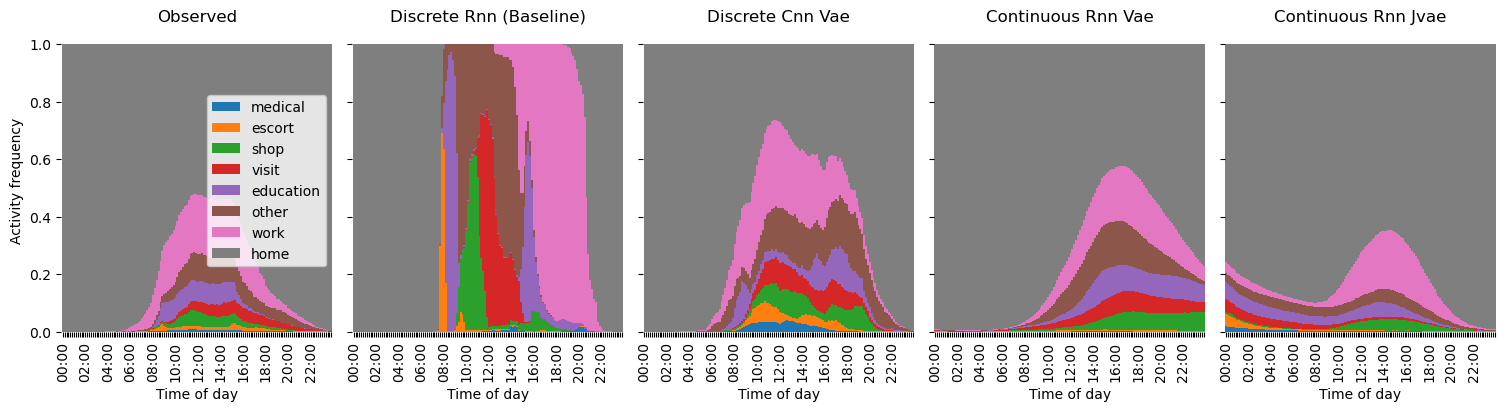

In [21]:
# freq plots
# fig, axs = plt.subplots(5, 1, figsize=(5, 12))
# frequency.plot_agg_acts("NTS", target_schedules, class_map, ax=axs[0])
schedules = {
    k: pd.read_csv(list(iter_models(v))[4] / "synthetic_schedules.csv")
    for k, v in batch_paths.items()
}
fig = frequency.frequency_plots(target_schedules, schedules)

In [3]:
distances_subs.set_index(["domain", "feature", "sub_pop"]).loc["timing"]

segment  feature count  observed  best_jm_z24  \
feature         sub_pop                                                     
start times     gender=M      home0        18319.0  0.000000     0.003086   
                gender=M      home1        18314.0  0.625418     0.028188   
                gender=M     other0         7210.0  0.532486     0.054715   
                gender=M      work0         4857.0  0.358418     0.075064   
                gender=M      shop0         3893.0  0.525128     0.047444   
...                             ...            ...       ...          ...   
start-durations income=4       shop         1987.0  0.592167     0.052715   
                income=4     escort         1605.0  0.574130     0.116118   
                income=4      visit          936.0  0.700732     0.068727   
                income=4  education          560.0  0.659356     0.154686   
                income=4    medical          260.0  0.572596     0.060665   

                         distance  
feature         sub_pop            
start times     gender=M      EMD  
                gender=M      EMD  
                gender=M      EMD  
                gender=M      EMD  
                gender=M      EMD  
...                           ...  
start-durations income=4      EMD  
                income=4      EMD  
                income=4      EMD  
                income=4      EMD  
                income=4      EMD  

[3218 rows x 5 columns]

In [4]:
from caveat.evaluate.distance.wasserstein import emd
from caveat.evaluate.features.frequency import activity_frequencies

In [5]:
sample = pd.read_csv("../logs/best_jm_z24/version_30/synthetic_schedules.csv")
target = pd.read_csv("../tmp/nts_home_schedules.csv")
sample.head()

,Unnamed: 0,pid,act,start,end,duration
0,0,0,home,0,675,675
1,1,0,education,675,857,182
2,2,0,home,857,1305,448
3,3,1,home,0,479,479
4,4,1,work,479,743,264


In [6]:
freqs = activity_frequencies(sample)
support, density = freqs["work"]
tsupport, tdensity = activity_frequencies(target)["work"]
emd((support, density), (tsupport, tdensity))

0.03128210155028198

In [7]:
from caveat.evaluate.describe.features import average_density

In [8]:
average_density(freqs)

home         0.856425
education    0.016305
work         0.065564
shop         0.018199
other        0.022943
visit        0.015936
medical      0.000595
escort       0.004035
dtype: float64

In [9]:
tdensity

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
       3.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
       4.000e+00, 9.000e+00, 9.000e+00, 9.000e+00, 1.600e+01, 2.300e+01,
       3.700e+01, 5.300e+01, 1.030e+02, 1.460e+02, 2.120e+02, 3.320e+02,
       6.000e+02, 6.870e+02, 8.420e+02, 1.094e+03, 1.548e+03, 1.871e+03,
       2.454e+03, 2.942e+03, 3.758e+03, 4.353e+03, 5.106e+03, 5.619e+03,
       6.425e+03, 6.652e+03, 6.901e+03, 7.063e+03, 7.284e+03, 7.356e+03,
       7.454e+03, 7.500e+03, 7.552e+03, 7.570e+03, 7.571e+03, 7.614e+03,
       7.654e+03, 7.599e+03, 7.553e+03, 7.546e+03, 7.566e+03, 7.519e+03,
       7.497e+03, 7.497e+03, 7.479e+03, 7.359e+03, 7.221e+03, 7.138e+03,
       7.040e+03, 6.881e+03, 6.691e+03, 6.552e+03, 6.385e+03, 6.078e+03,
       5.599e+03, 5.218e+03, 4.721e+03, 4.212e+03, 3.627e+03, 3.181e+03,
       2.589e+03, 2.274e+03, 1.874e+03, 1.678e+03, 1.416e+03, 1.295e+03,
       1.138e+03, 1.049e+03, 9.320e+02, 8.310e+02, 

In [10]:
import numpy as np

In [11]:
np.arange(0, 1, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [2]:
attributes = pd.read_csv("../tmp/nts_home_attributes.csv")
attributes.head()

,pid,age,gender,ethnicity,education,license,car_access,work_status,area,income,hh_size,hh_composition,hh_children,hh_cars,hh_bikes,hh_motorcycles
0,0,50,M,white,N,yes,yes,unemployed,urban,1,1,1adult,0,1.0,0,0.0
1,1,50,M,white,N,yes,yes,unemployed,urban,1,1,1adult,0,1.0,0,0.0
2,2,50,M,white,N,yes,yes,unemployed,urban,1,1,1adult,0,1.0,0,0.0
3,3,50,M,white,N,yes,yes,unemployed,urban,1,1,1adult,0,1.0,0,0.0
4,4,50,M,white,N,yes,yes,unemployed,urban,1,1,1adult,0,1.0,0,0.0


In [3]:
age_mapping = {
    1: 0,
    2: 1,
    3: 3,
    4: 5,
    5: 11,
    6: 16,
    7: 17,
    8: 18,
    9: 19,
    10: 20,
    11: 21,
    12: 26,
    13: 30,
    14: 40,
    15: 50,
    16: 60,
    17: 65,
    18: 70,
    19: 75,
    20: 80,
    21: 85,
}
age_to_idx = {v: k for k, v in age_mapping.items()}
age_group_mapping = {
    1: "<5",
    2: "<5",
    3: "<5",
    4: "5-11",
    5: "11-16",
    6: "16-20",
    7: "16-20",
    8: "16-20",
    9: "16-20",
    10: "20-30",
    11: "20-30",
    12: "20-30",
    13: "30-40",
    14: "40-50",
    15: "50-70",
    16: "50-70",
    17: "50-70",
    18: "70+",
    19: "70+",
    20: "70+",
    21: "70+",
}

attributes["age_group"] = attributes.age.map(age_to_idx).map(age_group_mapping)
attributes.head()
attributes.to_csv("../tmp/nts_home_attributes_groups.csv", index="pid")